# Beautif.ai classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize 4 types of natural events in nature/indoor/outdoor:

* Daylight sky 
  * <img src = "https://ak.picdn.net/shutterstock/videos/7077064/thumb/1.jpg" width = "50%" height="50%">
* Sky at night
  * <img src="https://i.pinimg.com/originals/ec/98/dd/ec98dd97904e60661b1d545a88006e6a.jpg" width="50%" height="50%"/>

* Picture doesn't contain sky (no matter it's day or night)
  * <img src= "https://www.hotelsolun.com/application/files/5515/6285/1004/1X9A8812.jpg" width="50%" height="50%"/>


This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Load Data

In [1]:
import os
from google.colab import drive
from PIL import Image
import shutil
import random
import cv2
from keras.applications.xception import preprocess_input as X_pre
from keras.applications.resnet50 import preprocess_input as Res_pre
import numpy as np

from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils
import cv2

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

plt.style.use( "ggplot" )

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def split_test_valid( split_ratio, set_path, random_seed = 1, print_ratio = False, include_path = True ) :

    """
    This functions lists through a directory containing different sets in sorted subdirectories and returns test_x, valid_x, test_labels, valid_labels ( or x and y ) for further use.
    The arguments that need to be provided:
        split_ratio: is the ratio for the data set to be split along. Acceptable input is a float between 0 and 1 i.e. the percentage needed for further use; 
        set_path: is the path to the main directory where the subdirectories are located.
    Optional arguments:
         random_seed: is self-explanatory;
         print_ratio: prints the int ratio of the split.
         include_path: whether or not to include the full path in the train and test sets.
            If True returns: '/content/drive/MyDrive/Directory/Subdirectiory/Image.jpg';
            If False returns: 'Image.jpg'.
    """

    random.seed( random_seed )
    
    total = 0

    test_x = []
    valid_x = []
    test_labels = []
    valid_labels = []

    default_location = os.getcwd()

    if set_path[ -1 ] == "/" :
        set_path = set_path[0:-1]

    os.chdir( set_path )
    list_dir = os.listdir( set_path )

    for folder in list_dir :
        os.chdir( f'{ set_path}/{ folder }' )
        how_many =  len( os.listdir() )
        total += how_many

        test_set = int( round( how_many * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( how_many * split_ratio, 0 ) )

        nums = [ x for x in range( 1, how_many ) ]
        random_nums = random.sample( nums, valid_set )

        # The split itself :
        for ind, item in enumerate( os.listdir() ):

            if ind in random_nums :
                if include_path == True :
                    valid_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    valid_x.append( item )

                valid_labels.append( folder )

            if ind not in random_nums :

                if include_path == True :
                    test_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    test_x.append( item )

                test_labels.append( folder )

        if print_ratio == True :

            print( f"Set: { folder } - { how_many } items" )
            print( f"Train: { test_set }" )
            print( f"Validation: { valid_set }" )
            print( f"Total: { test_set + valid_set }" )
            print( "---------" )
        elif print_ratio == False :
            pass

    os.chdir( default_location )
    
    if print_ratio == True :
        test_set = int( round( total * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( total * split_ratio, 0 ) )

        print( "---------" ) 
        print( f"United set: { total } items" )
        print( f"Train: { test_set }" )
        print( f"Validation: { valid_set }" )
        print( f"Total: { test_set + valid_set }" )
        print( "---------" )
    elif print_ratio == False :
            pass

    return test_x, valid_x, test_labels, valid_labels

In [4]:
set_path = "/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224"
split_ratio = 0.15

train_x, validation_x, train_labels, validation_labels  = split_test_valid( split_ratio, set_path, random_seed = 42, print_ratio = True )

Set: Night-Separated - 658 items
Train: 559
Validation: 99
Total: 658
---------
Set: No_Sky - 3791 items
Train: 3222
Validation: 569
Total: 3791
---------
Set: Day - 3304 items
Train: 2808
Validation: 496
Total: 3304
---------
Set: Night-Not_Separated - 887 items
Train: 754
Validation: 133
Total: 887
---------
---------
United set: 8640 items
Train: 7344
Validation: 1296
Total: 8640
---------


In [5]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [7]:
le.fit(train_labels)

LabelEncoder()

In [8]:
train_targets = le.transform(train_labels)
val_targets = le.transform(validation_labels)

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
train_targets = np_utils.to_categorical(train_targets,num_classes=4)
val_targets = np_utils.to_categorical(val_targets,num_classes=4)

# Visualize Data Distribution

# Image Preprocessing

In [11]:
def load_image( path ) :
  # READ AND PREPROCESS IMAGE HERE
  #cv2.imread
  image = cv2.imread( path ).astype( np.float32 )
  image_resized = Res_pre( image )
  return image_resized

def load_dataset( files ) :
  vector = []
  brojcanik = 0
  for file in files:
    brojcanik = brojcanik + 1
    vector.append( load_image( file ) )
    if brojcanik%100 == 0:
      print(f"procesirani se vkupno {brojcanik} sliki")
  return np.array( vector )


X_train = load_dataset( train_x )
X_val = load_dataset( validation_x )

procesirani se vkupno 100 sliki
procesirani se vkupno 200 sliki
procesirani se vkupno 300 sliki
procesirani se vkupno 400 sliki
procesirani se vkupno 500 sliki
procesirani se vkupno 600 sliki
procesirani se vkupno 700 sliki
procesirani se vkupno 800 sliki
procesirani se vkupno 900 sliki
procesirani se vkupno 1000 sliki
procesirani se vkupno 1100 sliki
procesirani se vkupno 1200 sliki
procesirani se vkupno 1300 sliki
procesirani se vkupno 1400 sliki
procesirani se vkupno 1500 sliki
procesirani se vkupno 1600 sliki
procesirani se vkupno 1700 sliki
procesirani se vkupno 1800 sliki
procesirani se vkupno 1900 sliki
procesirani se vkupno 2000 sliki
procesirani se vkupno 2100 sliki
procesirani se vkupno 2200 sliki
procesirani se vkupno 2300 sliki
procesirani se vkupno 2400 sliki
procesirani se vkupno 2500 sliki
procesirani se vkupno 2600 sliki
procesirani se vkupno 2700 sliki
procesirani se vkupno 2800 sliki
procesirani se vkupno 2900 sliki
procesirani se vkupno 3000 sliki
procesirani se vkup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

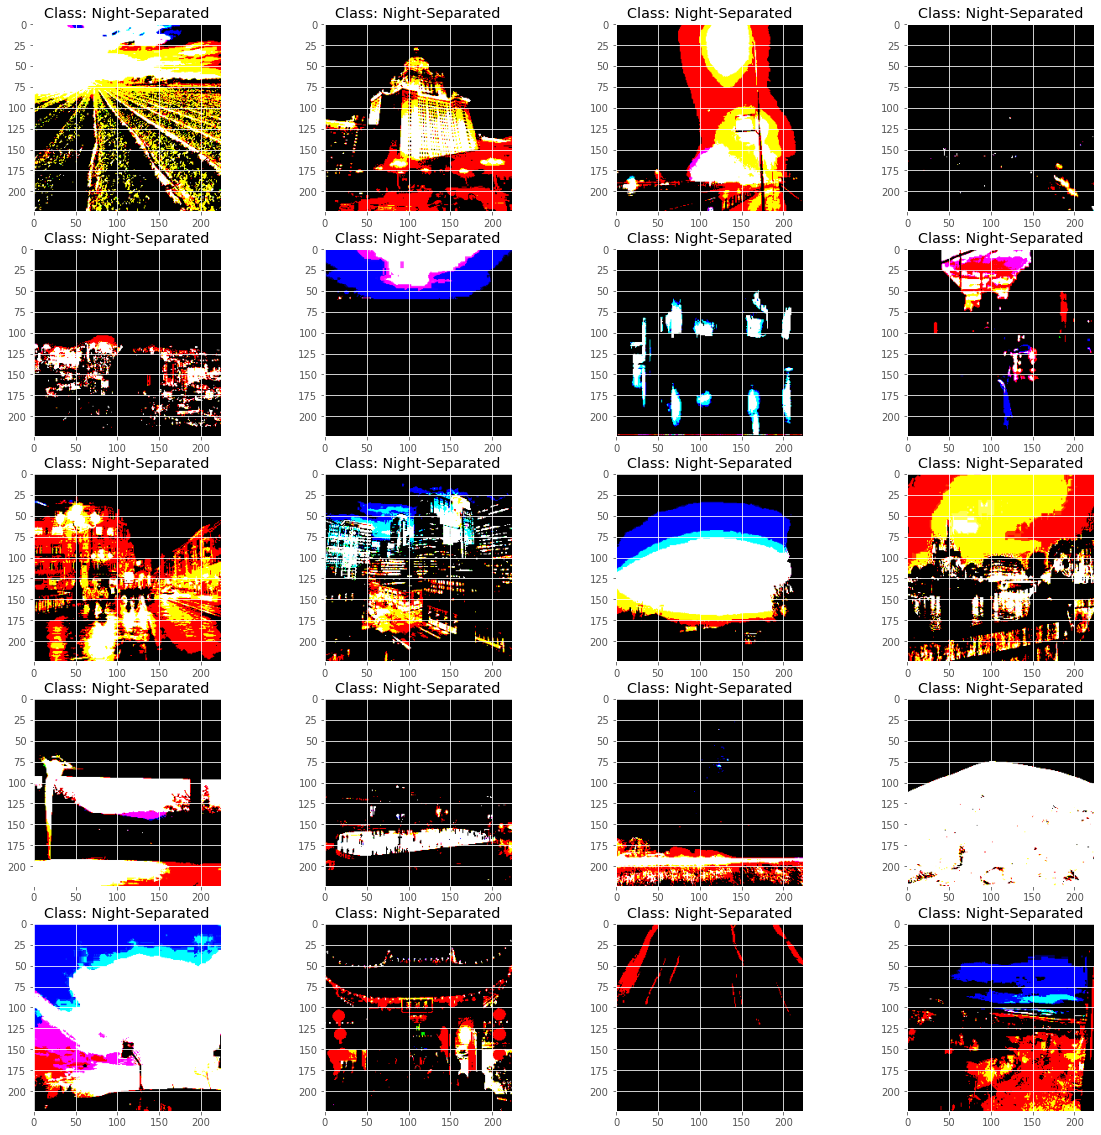

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_train[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + train_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

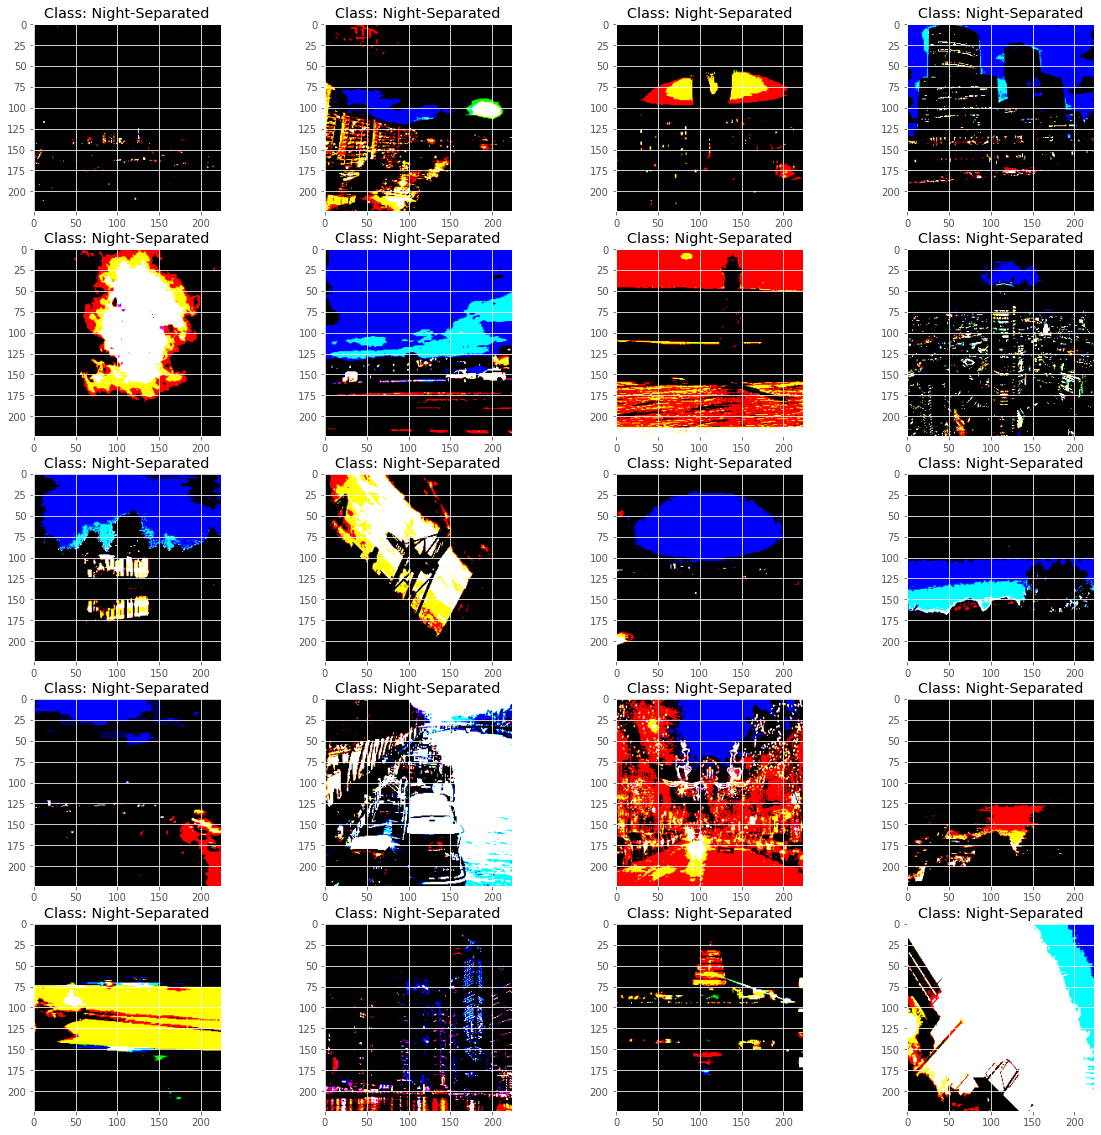

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_val[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + validation_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

In [14]:
from keras.applications.resnet import ResNet101

# Define Model Architecture

In [22]:
model = ResNet101(include_top=False, input_shape = (224,224,3), weights='imagenet')
for layer in model.layers:
  layer.trainable=False
#flat = Flatten()(model.output)
#hidden = Dense(1024, activation='relu')(flat)
#outputs = Dense(4, activation='softmax')(hidden)
#model = Model(inputs = model.inputs, outputs = outputs)
flat = Flatten()(model.output)
hidden = Dense(1024, activation='relu')(flat)
batch_norm = BatchNormalization()(hidden)
dropout = Dropout(0.3)(batch_norm)
hidden1 = Dense(256, activation='relu')(dropout)
batch_norm1 = BatchNormalization()(hidden1)
dropout1 = Dropout(0.4)(batch_norm1)

outputs = Dense(4, activation='softmax')(dropout1)
model = Model(inputs = model.inputs, outputs = outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Define Loss Function, Optimizator

In [23]:
optimzer = keras.optimizers.Adam(lr = 0.0001)
model.compile( loss = 'categorical_crossentropy', optimizer = optimzer, metrics = [ 'accuracy' ] )

# Define Augmentator 

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from io import BytesIO
from PIL import Image

In [25]:
X_train.shape

(7343, 224, 224, 3)

In [26]:
datagen = ImageDataGenerator(
                              rotation_range=10,
                              width_shift_range=0.1,
                              #height_shift_range=0.1, 
                              zoom_range=0.1,
                              #brightness_range=(0.5,0.7),
                              #channel_shift_range=0.9,
                            )

datagen.fit(X_train)


In [28]:
checkpoint = ModelCheckpoint(     
                                'best_model_Augmentator4_Ivica.pt', monitor = 'val_accuracy',
                                verbose = 1, save_best_only = True, mode = 'max'
                               )

model.fit_generator(datagen.flow(X_train,
                                 train_targets,
                                 batch_size = 15),
                    
                    validation_data = ( X_val, val_targets ),
                    epochs = 50,
                    callbacks = [ checkpoint ], 
                    )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
735/735 [==============================] - 99s 134ms/step - loss: 0.0933 - accuracy: 0.9684 - val_loss: 0.4971 - val_accuracy: 0.8859

Epoch 00001: val_accuracy improved from -inf to 0.88589, saving model to best_model_Augmentator3_Ivica.pt
INFO:tensorflow:Assets written to: best_model_Augmentator3_Ivica.pt/assets
Epoch 2/50
735/735 [==============================] - 99s 134ms/step - loss: 0.0871 - accuracy: 0.9692 - val_loss: 0.4699 - val_accuracy: 0.8928

Epoch 00002: val_accuracy improved from 0.88589 to 0.89283, saving model to best_model_Augmentator3_Ivica.pt
INFO:tensorflow:Assets written to: best_model_Augmentator3_Ivica.pt/assets
Epoch 3/50
735/735 [==============================] - 99s 134ms/step - loss: 0.0837 - accuracy: 0.9698 - val_loss: 0.4376 - val_accuracy: 0.8936

Epoch 00003: val_accuracy improved from 0.89283 to 0.89360, saving model to best_model_Augmentator3_Ivica.pt
INFO:tensorflow:Assets written to: best_model_Augmentator3_Ivica.pt/assets
Epoch 4/50
73

In [29]:
from sklearn.metrics import classification_report

Y_pred = model.predict(X_val)

real_prediction = np.argmax(Y_pred, axis=1)
real_targets = np.argmax(val_targets, axis=1)

target_names = ['Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky']
# print(classification_report(Y_test, Y_pred, target_names=target_names))
print(classification_report(real_targets, real_prediction, target_names=target_names))

                     precision    recall  f1-score   support

                Day       0.93      0.94      0.93       496
Night-Not_Separated       0.79      0.83      0.81       133
    Night-Separated       0.78      0.65      0.71        99
             No_Sky       0.94      0.94      0.94       569

           accuracy                           0.91      1297
          macro avg       0.86      0.84      0.85      1297
       weighted avg       0.90      0.91      0.90      1297



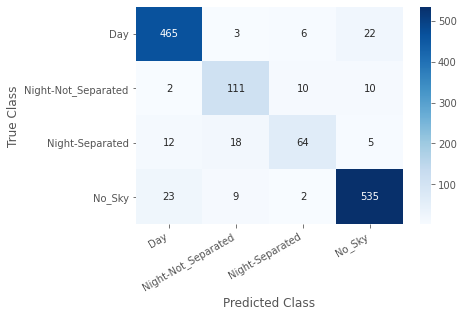

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_names=['Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class');

cm = confusion_matrix(real_targets, real_prediction)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Example :  
   Provide several examples of predictions along with softmax score probability

# Benchmark

In [31]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    # istreniraniot model go koristime za prepoznavanje
    prediction = model.predict(image)
    # prepoznaenata klasa ni e indeksot od najgolemata vrednost vo izlezot (prediction), najgolemata verojatnost
    predicted_class = np.argmax(prediction)
    return target_names[predicted_class]

In [32]:
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # PREPROCESS YOUR INPUT
  image_preprocessed = preprocess_input(cv2.resize(image, dsize = (224,224)))
  return image_preprocessed, image_

def predict_url(url):
  image_resized, image = url_to_image(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

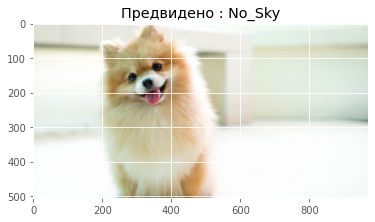

In [33]:
predict_url("https://d17fnq9dkz9hgj.cloudfront.net/uploads/2018/04/Pomeranian_02.jpg")

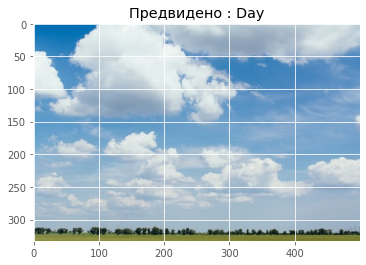

In [34]:
predict_url("https://images.unsplash.com/photo-1463947628408-f8581a2f4aca?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxleHBsb3JlLWZlZWR8Mnx8fGVufDB8fHw%3D&auto=format&fit=crop&w=500&q=60")

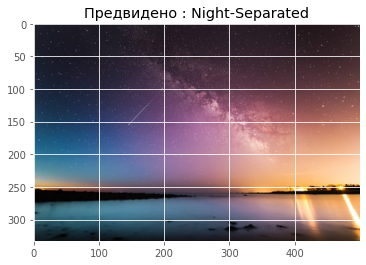

In [35]:
predict_url("https://images.unsplash.com/photo-1468276311594-df7cb65d8df6?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxleHBsb3JlLWZlZWR8OXx8fGVufDB8fHw%3D&auto=format&fit=crop&w=500&q=60")

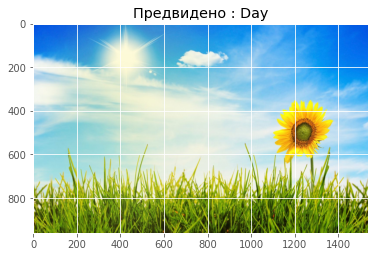

In [36]:
predict_url("https://scontent.fskp2-1.fna.fbcdn.net/v/t31.0-8/p960x960/10945111_1532150797037312_5930509058927773875_o.jpg?_nc_cat=111&ccb=3&_nc_sid=e3f864&_nc_ohc=FfcA0O6r2LAAX_L3gIe&_nc_ht=scontent.fskp2-1.fna&tp=6&oh=6b433ef1607a363f79d6bff5242a6112&oe=604F3D3A")

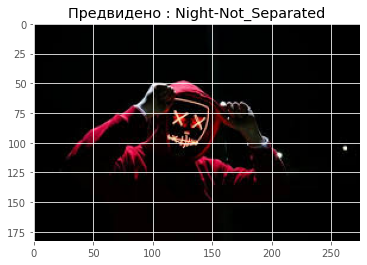

In [37]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQDw8QDw8PEA8PDxAVEBAQEBAPERUVFRUXFxUWFRUZHSkiGBolGxcXIjEhJikrLi4yGCEzODMsOSgtLi0BCgoKDg0OGhAQFy0fICUtLS0tLSstLS8vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBEQACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAAAQIDBAUGB//EADsQAAIBAwIDBgMGBAUFAAAAAAABAgMEERIhBTFBBhMiUWFxMoGRFEJSobHBFXKS0QcjM4LhJDRDYvD/xAAaAQEBAQEBAQEAAAAAAAAAAAAAAQIDBAUG/8QAMREBAAICAQMCBAQFBQEAAAAAAAECAxEhBBIxQVEFE2FxIiOB8BShscHhMlKR0fFC/9oADAMBAAIRAxEAPwD4aAAASAAAAgAAAAAAoEAoAAAGSHICsgKgCAAABQABAAAAAAAAAAAAASAABAAAAAAAAAAAAAAGSBYSVZhVQBAAAAAUAAQAAAAAAAAAASAAAAgAAAAAUCAAAAAAAL02VJRMKqQAAAAAABQABAAAAAAAAACQAAAEAAAAACgAIAAAAABaASSYVUAAAAAAAKAAIAAAAAAAAkAACAAAACgAAAABAAAAAALQBKZhIUCgAAAABQAAAgAAAAAAACQAAIAAoAAAAAAAEAAUAA0BFogkkVIVIoACgQABQAAAAQAAAAAEoAACAAKAAAAAAAAfReyPZWxp2P8AEeMKt3VeUoWlGD7vU4xb1SlzWpxajyW3XKLrUbI5lxqt9wWeV/Dr2j5SpX0JS9MqpTaM7XUOv2Z7HWFw3P7ZGvtB/Z1LuakFPLUZtpd5JYedGywNvodF0+HJOskzv2e3teB2lBYhb29PbGXGLk/eUstk2+9j6fFXitXC432Qs7j4Iwo1HylRcUv91POH8sMbcs/wzDljcR2z7vnPH+z9eynpqpOEvgqRzol6ej9GWJfnup6TJgtq0fq5KK8srSCQoFAAUCAAKAAAEASBAAAAAASACAAKAAAAAAA7PZTgzu7hRkpfZ6UXVuZr7tKG8t+je0V6yRYjaTOnW7Y9sqvEVToxhGjZ0MKjQgsJKK0xz7LoS1t8EQ8xQj5LLz15GZaiHQ4TXq0bijVopSqU6idNOOtSl5aevPl6mJmHox1tFomHY492l4l/5qdShH8M6Dhj5zRYiJ9X0MvxTNH+mO39HIp8fuOXfNp9KkITiO1zp8Tzf7/+Y4dS07RudOVK40qm448MFUpS3+/Tz4f5o4afmTx4emOunNTtzRGvfztxbvhyw50ZKpBfEovU4/o2vVpG4s+dm6T8Pfjnuj116OfI08EKYCgUCAAKAAAAABAAAAAAAAEgAgFAAAABKQHouz3Zb7S499dULOEknCVfW3JN48MYr6ZxkcPVHRZpx/M7eHt+1lxR4Xa/w3htPw3FOM695JqU6yecSTW2OeMbLfrk3b8MPHrc8vnCoaThMttV02n8+RdkL1nKHOT1fdxthefoI1Ph2t3VjmeWxadob2l/p3dxFfh72co/OLeH9CzSs+jEZb19Ww+0kp/9zbWdznnKVBUan9dFwf1yTs9pmF+bv/VESsv4dW5O4sZt821d0PyUakV/UPxx9SPlz44YryxqW0oSlOEoVE3RuLeeqEtPxYaxusrKaTWUZ3vw9Fd1t+OfPiYb3ZN2DvKcuJxk7dKTnCmpJTljw7Rw0vNLH6movwxbD3T7T/V0eIU+CSvJ0bWnV+zV5LTXq1KtOVvlYxGDzrWpZzLOVJLZ7mu5w7NRy5Tdjqk1aTzb7d2685QrLOluo0k4NPD8OE+W3MTKxWJa9ThcK9OrWs4zXcxc69CUlOUIdakJbaoJ4TWMrbmt1YnbEw4gQAAAAACAAAAAAAAAACQAEASAA6fCODyr6pN6KUOc8Zy/KK6skzp9DoPh2TqpnXER6vR8N7N0qVN3DqQuXF7Qimow9Zxe7f5e5nufX6P4TSlptlnumPRwuN8TdRtZzvu9xEPJ8T6+L/l08Q63BO0EaltO0ucycVKdtNbyU+q9n181vzSOvdHbqXxp/H93LqVoxWZPnyXX6Hn3MtRSI5swVbqEZfDqa/pLNZmNbdKdmO+5jemThFzF31GpWpRrQVWOui0tMoLnHD2e3T0JMRTHxw6R39T1MRrcz6PW8W/w7nK5qToSjTspJVlcVGoW9OlPxLxPy3WFl7I4U6mfEw9eX4fiivdFtTz+H14/s8fxe2tVc93ZVqlWh4IqrWiqeZcpSSXKGd1lZ9D1Radbs+XNIm/bRk492er2dxK3lHvJJx0zpqTjPPJx2zz2x5pkrlraN7dLdLlr/wDMzDYvqEqdhaQnGUZ/a7/VGScZJxjbxw0+TTTRnjumY+jrEfl1ifq0nR1U1j4o8vPBzi+rcvbfBN8MTXzH9GKjrcZOUH3euKlNRelTak4py6NpS29H5HeY43D5tbbtMW9VFjMkm879eefMOfiXR7OcVjQrTdTLo1KeirDSpxmtSemUXzWxqs6YnlzuLUacK01RlqpN5pvrpluk/Vcn7FRpgAAAAAAgAAAAAAAAAAASwM1ra1KstNOEpyfSKb+vkHTHivknVI29Lwvs9Tp+O7ak479zCXhSXPXJfovqZmX3+j+Caj5nU8R7MfEuPRy404qMOShBKMUumME1t1z/ABXFhj5eKOPo4tDiVWE9cZNZ2aT2a8mXUPiV67NW/fEtOUstvzbNPJM907WpycWpLmmmiEccr1ZZ588b/Pf9w1M7VnHDw+YLRqdOlwC4tqVyql3TqVaVNTkqVOShrml4Iyl0g3zxuYvEzXUOlb/Ly93t4ezu+2yv7GVKrKnb16FeP2elCOmk6U4tOCXLwOKeXvv6njv03bPjcPsdB1sd86nU2jU79/u8v2d4dO4unSpJTl1WpRTW+ZZeyS5/I65p/Lhz6Ltr1NrWnda+dev2/V9D43xShTsJXFpUpXd7w/uqc7jDlThGb0xqUk9qklLC1vbMnLG6OGLHM31Z06nqZrjtOOdUt49/1eB7STlixozk5VI23e1XJ5k6lzOVWWp+el0z111qZfOiJtatfp/Vz7ifdxjjmc6R3zO30epvPTY69vlZ1lUi4Rk1FyUnSy1FySazjk3htZ9TcRavl4ctsWbmvE+zSnavPI6xZ8+1ZidLU7dkmUUuqOEn5PD+fL9zVZJappAAAYACAAAAAAAAAAABKA6XCeHd63KbapR5+cn5L+5JfS6DoJ6i3dbiseXqqV7op91SjGnB/dgks+76mNv12CuPDWIxxEOBxzimf8qm9l8cl95+XsWH5/4t8Rm0/KxzxHmXCNPgAAECKN+hTSzUnuk8Ri/vS8vZdTG3spSKx32/9areW2+beSvPPM7l17nszdpwapOSq28biOlxbdJvGUur5PSsvDyYjLXXMuuTp79/HLRXD5wqyhWpVo91iVxFQaqQhmOW4vl8S543aN744cIrq34obvaiwoW1ZUqEqzaiu8jVUVKOpKUd4yaknFp5XmYxza0bs754pTUY9xPqt2XhOU6sZTlCz7uMr5rCzShOMtGfxSmoxWOba6ZLfUc+rGGLTOvTzLFe3kri5nWn8dWUpNLlFcoxXolhL2Oc8V09uGN5YmPMtTiFXVLC5R2/uaw11Dn8Sz/MyajxDTZ2fPZ6N3KLWXlevMzNYlqLc8unGSeHzRz+jVo1zAqUZS0yemEtnL8PlL2Tw36ZNV4c3Ov+H1qEtNalUpSe6U4OOV5xb+JeqOo1SABAEgQAAAAAAAAAASgOhwrh6qvM3ppR+J9fVIzMvo9B0P8AETNrTqseZbav450U1ppRzhc/r5k5e3H1tIn5ePisMN3xJpaYc3zf9iRXbHVfEpivZjco6PihBelSlKSjFOUm8JJZbLLVa2tMVrG5Z61hWg1GVKpGT5Jwll+3mR0t0+WsxE0nf2bn8MjRw7lzjJpSVKMd2vWT5euzMzb2eyOhjFqc86nzr/LUuq2t5wkltGK5JEhwzXm878R7Nc04S9nwb/ES/su5jCqqtvCnBKjVipRUVLdQfOLxlZ9Tj8mtonfl6c+XVomI4mIem4Vxixv41406FvC4uqsaMaFem1KUXPvJN1LdKWHohu4+Frdyycb47U09GLL839x/d0eM0OCTlNXdxbwWHU2qTrVMTjTjScIqCa/y6MHz21v0ZmvzfNVyXw9upiN8fve/7ej572xuLSjJWnDKveWvhnWqJSXeVt+r3cIrGF0blzPVji0xu/l4b3rHFI1DiUfBB1Hze0P3ZLcz2vZi/KxTmt68R/208/qdtPlTO52ipHGPWKZUhQK6PD/9Ob1x8MoJQedclLVlxWOS0rP8yMWr6ulJ3w2KMsyXhk1nfCZIhm0ae049eUlw37M6yuO/VCNJJNqhKEk9SlL7zSUGl0zvk9No1VMde++nzOS3OSSgAAAgAAAzW1rUqvTSpzqSSbcYRlN4XN4XQDFgCAAAABmtaDnJRTS6tvkkubZNumLHN7dsN65ulGn3cHs9vXHr7mIjc7l9LP1NceCMWOXNz5HR8qJmPCCABKA7PZr/AC6jrtbUoy0+Tk1y/pz+Ri86fZ+EY4jJOe3isfzetqcRhOEKkZtRafxNNxfXH9jM+H62uWl8fzIl5jj83UWXJqdJ7wctSxL70G+j22LV+X+Kz8z8W9Wr5j6e8ODqOmnw+4TC7S3nHoEtO4ZKNSdN6oTlCWJLVCTi8STjJZXRptP0Y8sxMx4YclRs21DPiltHPzfojna2uI8vZ0+CLT3X8fzlW7rub8ktkuiXoKU7YZ6rqJy2+kejEjbyJqPOPRY/NsEMZVWp5ysZznbHPJJarvfDNK6qLZzlt6sQtvaVe/njGp4fTJdpEzHh6/sp2YXGJKlSlSoXEYtuck1CaXRpcpdcpeeTG3rz1x3xRkpxPif+3muOcKqWlzWtqunvKE5QnpeVldU/I1t4YlzyqAQAAAd/sf2sueF1517Xu9c6bhJVYOcWm084TW6aXUkxscKUsv3fsUVAAAAF4VGk0uvMNRaY8KhAgAMAZ7Wnqktk8b6Xlav/AFz6iXbDSLW/fP0dO7v4zjBxgqfNSjH4VhYX5NfQxFeX0s/WVtSOyvb7xH2a8br/AKd088pRa9ns/wBh28ucdVMdNOLa1V97Rz9+lz83D/h/qyRxOlyz8/B3R5r5+3+HLZ0fKAGSiWyKmOwWJ15eo4RO3o+Kcs1sRlTk900+iXT3OW/o/UdB/DYY3kndpjjY7qhWqVI1bem6nSa1Qcl0zh8y7mI2kfwvUZr0yY4i0eNeq1xwa2lTWjNKtjZuTlCT8mny90Xua6n4Jgmn5U6n6y4V9ZVKccTpYUJSzUW+c4xv5bbe5uJ2/N5ujzYN99dfX0aOCvOtSm4yUlzi018hLVbTWYmCo222+befqRbTMztUMtzhnE6ttONSjNwnCcZRkm08x5chMNRaYjXunidR1Ks6jbl3rc8yblLxPLTb3bTys9efUM2rqeGiwgAKAEASAAgABIBYzvyAMCSKAQBKAyKWlNddg3uaxMLSq5Us820/mFm+4lNpT1Sx6foZtOodemx/Mv2lGs4zz7p+z2LrhMeWaZP+YlgK4SgqAQIoUbsFrov8VF5/2Pn9H+pnxL2UicmGfev9P8JqVGu7qr+WXuv+Ca403bLMWpnj7T94ZrniD1Rw3hbma193q6n4habx2zw6sOJKjCNOqtaqR3T3Wlrr7vJKxL6dutx4sUYc8b7o/kxWMqE8xhbJRim5Sfjn7Zf6C0z6uPQV6XJukYtxHmZ5Uq8Pt345ZpR5uEJJ7ejfX8hW8+rOX4d0s/mTPZHttx73RqzTTUHyTeWsep0jb4eeMfdvH4a5XACMkd1jy3/+/L6AlDSDKmQGSqgABAAAAAAAAEphUkAKAGE8gGS3rOEtS54a+pJjbtgzTiv3VY2yuU8zsYAIgqJIqCpLZsLhQnmScotNSWcbMlo29PS5oxX3aNxPEppSxKUH8MtvZ9GQpaNzj9J/cMLi9Wl808fsVx1q2pTVnmTbbflnfboGr2m1pm07bf2lQhGC/mnjbLfJe2DOty9sdT8rFXFH3n7+kNWpcSlnU85wXUQ8d81777p3tNacXGmksSjHEvXfK/UQ1lvS1axEcxHLCVwAqUwiuSoAAIAASAAgAAAAAAE5AkjQAAhgSgIAkABDQSYABSUxIsM1xHEvkmn5royQ6ZI7bcMLZXOQIZCgEBAKkABGSsmQGQIAAAAAAAAAAAACUBKI1AAAICAAEgAGAaAAGaM046ZdPhfl6ewbi0TXtn9GFhzQBIUAAAIyEMlRAAAAAAAAAAAAAAAAAAAsRQKAAICJCgAAAAASgkpaCbUyUMgMgQAAAAAAAAAAAAAAAAAAAAABZEWAKAAICJCgAAAAATEJKZBljKoAAAAAAAAAAAAAAAAAAAAAAAAWRFgCgAAAAAAAAAAQZlZhFCqgAAAAAAAAAAAAAAAAAAAAAAAAlEWEgAoAAAAAQABQBEMrsIxlUABAKBAKAAIAAAAAAB//2Q==")

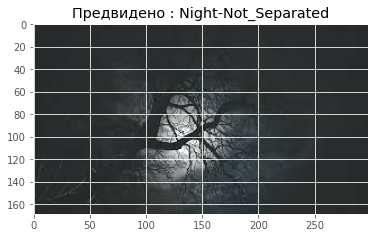

In [38]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTal6nSKLhNL8KkKlHf4uv_PbknncdEKST0qQ&usqp=CAU")

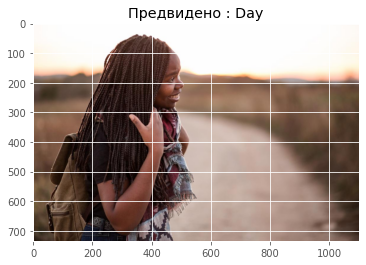

In [39]:
predict_url("https://cdn-prod.medicalnewstoday.com/content/images/articles/326/326378/a-woman-out-for-a-hike-wondering-if-black-people-can-get-sunburned.jpg")

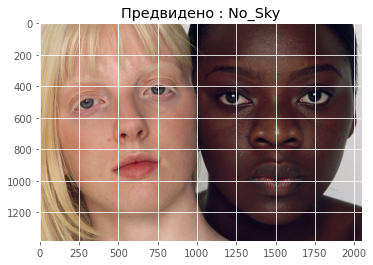

In [40]:
predict_url("https://www.nationalgeographic.com/content/dam/news/photos/000/774/77403.jpg")

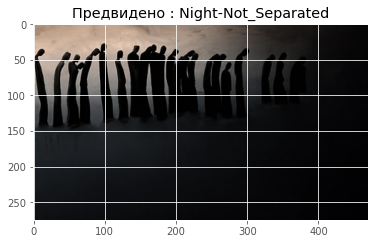

In [41]:
predict_url("https://www.markmallett.com/blog/wp-content/uploads/2015/03/people-walking-in-dark.jpg")

# Summary about your results

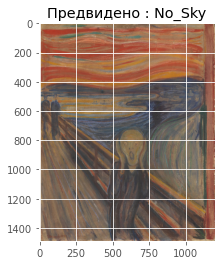

In [42]:
predict_url("https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/1200px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg")

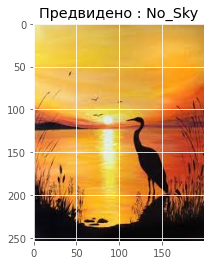

In [43]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUSEhIWFRUVFxcVFxYVFRcVFRcVFxgdGBUVFRUYHSggGB0lHRcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0lHyUtLi0tKy0tLS0tKy0tLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAP4AxwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwEEBQAGB//EAEYQAAIBAgMECAIGCQMBCQEAAAECAAMRBBIhMUFRYQUGEyJxgZGhMrEUQlJywfAHI2KCksLR4fFDorJTFhckMzRjZJPiFf/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAuEQACAgEEAQIEBQUBAAAAAAAAAQIRAwQSITFBE1EicaGxBTJhgfAUQkORwSP/2gAMAwEAAhEDEQA/APqjAGVKks5oiqJ5yczXFe4otBMgiATM7yjlA5jFGGYIEr1bC20LIi2jyIJWVvLKzRZEtZJBWVZdlJkglDLjDlFtJwXuKZpmB2RlsmASJOArYoLCCiHcSBC30SmcBOKwxJlvIibWJNOCaUsm8i0HegtrKvZawGpGXYEikiUyiaZgspl0iKqCEmmVyUXB3To5hOhWinZ7gtFOZLRZmV57YlRIKwCBCaLaU5hqJxMWWksIsiC5BKJxaQZNpBUytxdEWgkTiIJl7kDRDJFMkYSYJhKcWWkKKQckY0i0vcgkDlnBYYEICXdhIELJyRoWMCCCw0I7OT2Us5ZIWCXZTNKC1KXiIDLJZCgUinSX28IlxCTKZnVBOjqyzoxMqj1OQcYJSGYBaYFNszUA0WTDMEiW5sNAEwCYwiAQIO4IGCTCNoBMreyUcYtoRMGWmyUAZBMIiQVjUSgDIh9nB7KOSLVBJCEHLCWUwkGIxRFhoWaC5BpDLyCbRRMjNFuYaiGWg9pBMAxe5hqKIZ9It4wTmaMiymio1OdHFp00J8CHdm1cmCZBuNokCpFwiumBRxMBmjM4gkRqxRZBRMEgxpWUaGHcVajs3dOVaa/ZVR3uXeJvx0GuwA/QRdlh9IEaRBywPQRLAYwS8MrAKyv6csWzTs0IgQDaWsVEJzyO0PGBeLYwZRZaiParO7aVyZwMFxYaihpr6yBieUWGk54DgNSQ8Vr7pPaRHaQrxbjQxIaasWakAmDFMYooYXgZoBMBj5CXG2yOPA0tOlNqk6a0nRn9M9gaekS1PlLGaQZqpMwptFNlgZZdZYiqgAufzwg7A1ITmMjtI0ppFMkm2SC4ZBeRnEErOyyt0kSkcSIs2klYBWXvfkm05hAZZMi8pzLoE04JSGzSM0C4l8iykFljhOKycE3FfLznBZY7OLZTBk6GRlYOWTJWlDSnzmWcrNEWhdjIKRzWEr1KggpWMjbONhK1arAq1pRxGImnHEZsbH1KoG+dMStXJPKdNix8E9A+qWisRVtYDVm0UbuZPIfnaIBrAC99OPKIwlXNeofrfCDtCbvAnafIbpmhkceWcbYx+HoLTzG5JY3ZmNydP9o5Cw5RlNLnMf3R9nn4n+3G4Z7/AJ37pJMbHUxfYLiPKxT04Pazu2mlOMitskAacBlENnimPORxQSsEqIvOuYqDqBcjeAePDf6GDicOr2uDyszKfIqQYvC4cU1yi51LEsbsSd5O/cPAAQajQXI23KCVknWRlPCLqy7BIgkCLxCVb9zIBp8QZzz0BFtY0qYLwWVYIPjO9Z0i8D0aLItCAtBLSLwXifuHElq1tglZ6jR5qCKq11g+gkbMXyKz1TEVak6tUEpVXEKOI2xiHVriZ2Lq3FybD24RhflM8YgVGq0mAspUEEaFXQH55hNOPH5LlJL5jjpOlanUIGXaV7vjvF+drSY7aS7PVL0peyHYfi0+qNoPjs8LzWXpAGeObpAG53sbA22Ab/mfMSxQxik3DW3Dy2n88JMukvwYUoyfJ69MWOMsU61988nRx35GssUMbfvX03c+cxPSyTI8CfR6gPOBmHT6T43+csU+lRxlbZx8CJaeSNcLeT2HhKVPHod4lujWG0WPnInfZnnCcQvoxhfR5LlmBCEK24kZgP3bi/rKww+ItlNZeJdaYD8lCkso8fbfCUL6MspyXY84fnAakOMv4fB90XYnTabXPPSw9oFbDBdsZ/RZ9u/bx8xXrq6szmQcYFpdZRwlapbwiHjnDljozsr1BaKZorpDpClRUtWqLTA3swHpfbMHDdd8DVfs1r6k2GdXRSToLMwtG445pcqLocpJcNm+XHGLasBKtXErxlV8UJGzdjwtlqtivCUKuKiq2JEpVcSJaTZvxwUR1etcEHYdvhM+m5Tu3JH1SdT91jvtx4cxcrxOKIBNjYbhqfSVDiAwBDAg7wZpx4pNfoFLJFMvPW5ygTasal/jQKeN1NwfQmJOIW+0m3CVlxYYqVU2LEa6WIBBE048LRnyZU6LuJxAXM33T57PladKbVCwBy6Hw8fwnRqxryJeR3wTi+nKQJy30UKpVSo5nUjZYfkyjX6yAC1NW0t8Tf5ln/sZiCL3QeJBi26l1xa7Uxe+87Bt2Dw8yJu3af3OP62q8L6FQ9a6p2qpHiQTyvLtDrZe2dSo5HN4brxw6g1bXNanfgAx14Xj1/R6++uv8B/rFyy6X3DhPWIu4XpxG+GqAeBP4G00E6TbeARxtMn/ALvf/kj/AOv/APUbR6gZdmKYfdS380zSelfUvobYavUL80DfoY2kfiIHhpLCYikNUrW8WAmFR6n1FNxjqnmgYejMRLqdXam/FX8KCD8Znl6C/u+45Z5S7i/ob9Hpe1v1it42PyM1KHT6galfIGeVToE3/wDO9aQJ/wCQ+U0cJ1d+1XJ8Kaj8TM8p4oq0xeSOF/ms9dgen6TCxYA/OBjul6ZFgb24g6yjh+qq2v2x14KsHFdVwBftn9FHym9z1Lw+NtdnN2aJZOJP5CK3TCjYvsTMvpLErWXKS4G/IXS/iVIMdieh1X/Vfz/xM6v0ap+uTMEZqfO46OOGD+1GRi+gcGb5qK3O1iWDeOYm954rrL1fpUE7SlVuMwGQkE2PAjh4T3PSGEpUqbVX0VRc6XPgOe7zniaSnpCuEVSlFO83G3O287BwF50dLuXxb3S7sVqVia2qK3Pr3PUdGdJXoUizjNkW+ut8u/nHNjRx+UL6AgFgOWyKbCJvEzOGFu+TbHJNJIVUxV/rj2lWo19r+8snBU+B9Ys4KnwMdH0UvILc5Fapa22/mf6yg9MDvA2+0B8/GarYKnwPtK9bDU1IIBve1iBry8dNI6GTGuEBKEu2Uma2oN/l4/njKrYhgzWtrZ/3hofYCXcQiAXUXXMD5HR1PhcsPDlG/RqegK66p/tvf2941ZILwJeOTfDKKYhwSNNuYfvbfe/rIl+pTp5Q+UaXPMg/3I9J0nqQfgt42uLPbGsSCTprflYf4lLBO1QhiD3++BbZTXSmDzJ73tumn9HDIFBuD3DzC6N62I84ynTIJO82A03DZ/MZyHNJP3NWy6YpQeBjlB4SBdiQPhBsTvYjTKD8z/e1nCHOSQO6pKi2wsNGI5DZ5GJbCdALRbhDGHbgJopTjlpcomTk+hTkkZX0c8JP0Y8Jq9lIKcplnLInyDvRnChvmjgdTroPL/MjLyEtYdOKj0gxbl2JzSW02cMNNgHhAxg01/H5CMwo7ulhIxdMEWJA5meqlzo+PY4P+Tk85jgLfERf875g1k14z0WPww1sb+1/eZNTCmef062o7+mlHaeH/SFVK4S32qiL5C7fyiUv0dsOxq229pr4ZRl983vNv9IOBLYNz/02V/IGx9mM8L1O6VFCuAzBUqDIxOgB2qx8DcfvGdzBHfpWl7ics1DVJvqj6MTygm3AfnyljLcAixB2EWI9ZXq0G3EekxJ8nUUUKdV4D2iKgG4fKG2GbiIpsMfyYxItcCHe24SnjQHQrsvsO8EaqR4ECXnw5ESVtw9Ia4djOJKjLPdJFtH28BUttHIn5xtSsNDbePXZ+J9JZr0wwI4jjsI2GVLhqd99jf7y6H3Ebd8itlfCHTe9hbTvD0OkmQjBbknf8xOlBqC8s9/hKQVMqjRFVFvr3iL2PqnrHLQt3bm5G3f+0wG7cB/mRgagPnVc/upcA+ySzUQ6lSAWstzrlG6w43ufzacicnuMu/gqvSJASndQO5f7P22B4gd0Hix4TQo0QoCqAoUAAcANghrTVF4Ko1J5akn3MKncgEixOtuHLyip5mDYa+MYFPGAKcPJzlRyMCQYpc4DIBtMCoD5QPKLyZ30itpJK8ZbwlcE2225SkbcI3DvY6esVGTvvgHJFOJ6Kjs3QMQlxskYRrqIVfZPU1GenUXzwcF3GZjYiodRMyo3MzRxZIOlpl1WPH2tPOJ7HSO3gVop4+gKtN6bHuupU+DCxnwXF4dqbtTfRkYqfEG0++uJ8k/SLQy40kC2dEbxOqk/7Z2vwjNc3B+eRevx3BS9jz2FxtSnrTqMn3WIHpsM9L0L1zqKQuI7ynTOAAy8yBow9/GeTMidrJhhNVJHPxajJjdxZ9iNYWuDcHW41uN1rRLVh+RPPdR8fnpNSJuaZ0+42weRB9p6B5w8q9Obiz02Cay41NeRNWsOflKj1Bzliop3H1Ep16baG40Ye/d/GFGmPppEVGGnjw8pXpIFZ1toylxpvGjD/ifOWGQ20IB3eO6V8S+qNf4bg8g42H2PlGr2ByUuSzVKJdmsAGG22wrb5yYOMw61AVYaEKT5E/2kyR21zYM918I9Z0NU/UUGPxMo9++3/ECbNySLbBr57B+Myeh6QIVL/BSKnfZrKh9Mp9Zp0XGZKY/a8ctMhfmR6GYcuJORljJbTsaGbJTH1mGb7i95vWwX9+WsTiMiM52KpY+AFz8oOEAapUP2TkHoC3vb0jelKAehVQaFqbqPNSIl4lwmLlJcsnCYsVFV11VwGB4qwuD6GWs44Tz3URCOj8NnuG7PYduW5y/7bTfFuMRkhsm4rwwE9yTCLjhALcpOaAzRUlZaQLAwqIJPxWi2edTfXWIpJhSXBv4W1tLnneMqvpslLD1T9q/lDqVjvnRWrezaceWL4zKxz67PaUHaXscx3Wmc95h+Z1sKW0B24zwH6UcDmp066j4CUb7raqT4EW/envKjW2zN6RpJURkcXVgVI5GbtHP0cqmkNyYvVg4nw8yLzS6f6JbDVch1U6o3Ef1G+ZonroyUlaPOzg4ScZdmx1UxvZYlb7Huh8/h9wPWe/etynykNbZPo3RfSJrUlfS5Fm0+sND/AF85zdfh5U/2O3+D5U08b+aLNR/zeVquv54aj8I9m5RRaYo8HcopYrFFDTA1DNlPmDb3tKYc9tUXcUR/bIfzyj+mEJRLbRVT52/pHHDjtC//ALdve/58Zpi0o38zDk3SnXs19ia3SISxffbQcdTskyriaebE0qfAOx8NQPnOhxhjpOQiebNuaj0j1HVTpMHPVJAU8T9csM1/VfUzZ6HrCyVGY3ZC3gtRjU+Sz5L0d0jakaOt27RfJwo147G9p9EwFW4bK3wIlNRfe1Ox09PSK1WHa2/f7GfTZVOKN7q9UZqZqG4zm+U7QD3u8NxJZj4ERfWHppsN2HdzCrWWk37IYHUc9B7xgrLSXLdhtAO7Tab7M128zKWJy1cMoqIb0zRbbfvAgXvtO1td4POYaTnua4HN1Gl2ThsfUOOFD6lLChm++7rb2T5zWq40q6pa+bQW3Ebb8rERdKigqNUAszqmY8Qt8o8rmVXrDtVtluzMoJJsVC3bTewZbW4a8oh7ZvhdItKlz7msapnCrENVUMFJsSCR5WB+YjQOZmWTrtB0gjVEJKkUUPMzkoG+oMTTbBaVcmzhKt46psMTg1I47N5uPKNqg2/uJclycuf5jJxlT9mUHrSxjqevxfnyAmc6GGdLFFOIb1RKlXXeIbKYo3j4OjRGNHl+vWHvhWYi+VlItuubE+8+cYiiyGzCxsD5MAw9iJ9a6zoWwtcWv+rY+mt/aYmP6HSviFzjR8LpbQhlYWYcwGE7Wh1Shj+L9f8Ahg1mmeXJa74Pnc9n1MP6lrnTOfLuieZ6X6LfDVDTqDmrbmHEf03TW6mVyaho7ms45FTY+xHpN+oqeK0+OzJoG8WoSl30ekq4n4CuoY5T+JJ5AH1jaBvf86SpWwgNOimX4jfwsL6cNSB5xwo2Zn1suUAX0JfKDfw0t4mc1qNUehU3u5FYlmDADZf3DD1ve3nIz3BK6/EB5G34RWGrZqjrbVazU/XvA+WUxBQqrICb7dv1nYn+Uxqh4M8s3ldHYak/a2JIfVM+3ui9uVzYHynQ6GIYuSO8M7C+/LlUrpv3CdGSUmJhOKXbPJYNwtSmx+0L/wAWvtPc9TuljdKeXU1iQ25kCG9uIDZf4p8+YKBY3zXGm7LbX3tPS9EY9KYXWxV6zAjZZ6KkL/GBNephvicbSz2yPoFDH1KlemAVKCmtUhl1AbMTY7zfs92+WaWIY0WUkXTKreK5P7+k8jgcQErC1VszUKJXeEUoe0Yi2oRQSL72E1+mOsGHwiBAC7OVJRT3lUqCCSd+VRptJN5xsuKVqMVfR1YSjTlJ0el7YkIAdXy+SgZmP4ecy6VNjXAtoK1U3vuG244d63pMvonpfM1OxAJyUlva4NQM5NuSIgnp8HXBAPE2B2k37w9QAx8eUyThPDaa7GqsnTIxOYVQSVYC7LuZDbKw/aUgk+I9LfR9csXJOxiACLEAfPXNrvsJm9MVggNVrALSrAHeDdba+F5qdHWILAjVmGmzRjf3LTPkf/kn+xH20Xcx4+0JSePtOEIWmL1aBaLlA32m/l/aNdQeX58JWoNbZ8xGluIPqI15XXBinj5MzpFb7/nM11mtipTqJ4S1mt8o24uEZreEqLigzlLWIufEC2vLUkc8pmlVpTz/AEcihyUJy31FlsCSVuMqgAHKG03WO+asUIzi2aHLlFjpmqEoVmIuBTckfunSZJcirgF1zGnUDDfl7NSSf3gJa65g/RHUGxcog0udXG7fpeYnTfSAw+NolzcU6FrAG92uL+wmzTYrhS7+L7V/0Rnmoyt9cfc3uk+jqeJp5HXMp1B3g7mU7p4bB4BsHimuykBWCG4u2awXu3vttKvSnWevVuocomwIthpwuNfeV+hqQ7Sg5N710XLt0uDf8850tNpZ4oNTfD8GHPqseSacFyvJ6jHljRQUioqglqdyLkXPwX0JykReBxzV8I67KtIqG3GyEEEjd8NvEGaq4ek2ek4DKOzQWsP9IuHUjZoNDMrB4fsjVYMTcPTqE7SCuakx53DoTvMVFxcarntGuTkpp3w1TLFFQlaqcv8AqNVO87Kdxp99pRqZwHIG1kVuIDKoW3m7GD//AEP11RgRY0VJ14qisLcb28xG0K5rHKNBnQ6aWCozWPmgjNrXL9kKeRNUv1HYIENVNP8A6oA12d0k/h6SYPV9LhSxAQ1KrtfgFFMXP3rToufDLg20eDMtV8SXOcgXsg/gVV/lvKrNAzTstHCTaPT9X8epNY1XAb6O1JBbvPoQqLuBvl9JpdOYtH+j1cmehTFNKjaENVVQ2UnabA2PgRuFvDZpYTHPkCZjlF7KdQLkMSBxJAmeWnue5GmOoahsZv8AVytesrMwBz1ieWZFRWA5M/tPbdFdJ/qGxTaK1VaVEcndUY+twOASfJ6dU62Ns2hPIkH5gTf6T6Vc4WlSVWRFfMtwRnKg2bNyBXZvuYjU6X1KS9/oNwarZF/zk+n9YaSVKLoCScjOQL/DYjbz0032mx0XQ7OmF4Fidd7MWNvWfPehUqVKQq0S4VMgUMSz1TnCvVqAnW/fVV2C3O891gKTFULNclVJsdL7dOVz7Tz+rxenBY93F/U6uKSyPcbC2h2ERTTjeWFAnLljj7lyDpjgfeGWHGCoTifSGAp2Ew4pfp/szyKOKvuN/KVHZuEv4pLaiUXJhvan0asXRnYnFd7IGytYG/je2h2jQ/2mZVUgWH29QNFCqSWsN/dFrG+h8Jf6RonVlF2vT/hD6+xaYWJxi0VcVGAABWxOttbAaHavZDYdpnQ08E1UP9BTkl2Z/Wrp5adWlmRmFMlhcAKz2Aup5ag+M8J0pj3r1WqVDck8Ld0bABw1icXWZ2LMxYnexubbrxIM9Jg08cSVd0cHUaiWWT9iRNbGB1o0VylWZywurK+wKNu0G42cDxmSTNbFdItV7JtSaQVQLAa2B0sBtKE+sbO7QvG1TNyniB9JKqe4BTpi2w5EKIfC/wDyEZjcatPtXJuGq5fHIWdV8LEDzmOtUUQH+syBtdzByFFjwVREYutemoGoDViCdoF1sTztaZFitmv1qi157KGFU67bZWJtp8Oz3yn0mzhsQ1NWO9iwXmeztfX73tMypVAW6m17hhy7hAt4/KWBir9mGPwgi533YnXyI9JonG0Z8clFk1MQB+qbMV+EgaabT55lB8uciUMXXLMW5kjzMiEocAvK7KZg2hssHLHGcgzhIMkGQgayy+NqMi02clEvkB1C5rZrctBpKl5IaU0mWm0fWOi+kqXY06dNMqrSZwCe8URG/WG2y5uR4Ta6Y6w0ujwgq5rsvdVQPhW+8nmBPimHxrp8DFdGXTbZhZh4Ebp6zqv12NDMuKV8QjWtmYOyEbSoqbb6aZhsnH1H4bb3Lle3l/udPHruNvX6ns636QqFQKuHrolRiB/4inUyi+66aed7TR6y9cFwSoHUVKzDVEayrbaxJ1Avs011nja3W6nVbu4urhkvoBgaJA8w7G/OaHQ/SWAztVxWPXF3UC1bB2tY6EEoTvOgttmOegxxpuDpeOW3+9Beu5WrV+/8Zs9X/wBItCuy06y9jUYhQL5qZJOgz2Fr8xv2z29M33TxGH609DUSMhpIV1Bp4VhYneCE0lfpL9LWGS4o0alU7ma1JCfO7W8hMmTQSnK8ONr5l+sor4mme7xSnjpwlB/GfJMT+kzGvf8AWIgOwLTBsNwu15nVevWOJ/8AUnySmP5Y1fgmdvlpfz5Fw12OK8n1qjiQ2YZtQWXkLFl180b0ny7r50kKlXIoXKDmutRKlzYJrlHdNlGlzsE83jOkqlUs1R2Ysbm50J45dnHdvMql51tJ+HLBPfZn1Gt9SO2grzrxeaRedMwDbxi1yBYHT/P9TK2admkZdmpi64Iax0LBhfjlFx5EmVkqkZhxUj1lQvILGCo1wW5XyPepe8lsQSSd55StedeEDY4POihIkIW2WIYS5Upb4grCKEGRGlJGSQgNp1oeSQRIQEGGDOAk2kISGnF5FoJlFnF4BacRBMolk5pxMicBIUdedJAnESEInSbTrSEInSbTrSEInSbTgJCESQJNodpCwLToy06Qs//Z")

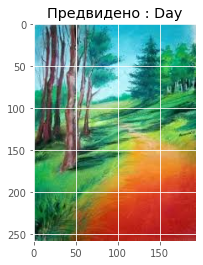

In [44]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNkXFdylul-HjD-W-gQRKd8_p9xS-xVcXn4w&usqp=CAU")

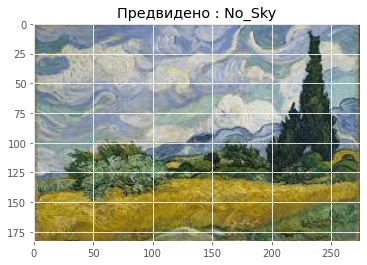

In [45]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGCAbFxYYGRoYHxoaGB0aHRsaGBoYHSgjGholHhgYIjEiJSorLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGzclICU2LS0tLTUwLS0vLS0tLS0tLS0tLy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAADBAIFAAEGB//EADoQAAECBAQDBgUCBgIDAQAAAAECEQADITEEEkFRBWFxIoGRobHwBhMywdFC4RRDUmKS8QcVI3KCM//EABkBAAMBAQEAAAAAAAAAAAAAAAECAwAEBf/EAC4RAAICAgIBAwIFBAMBAAAAAAABAhEDIRIxEwRBURQiYXGBoeEyUrHwFcHRBf/aAAwDAQACEQMRAD8AVwuDQoOJaCDcZRv0hxHBsObyUDkUJ/EL8MxCfpdlC3N4eUs1BZoZY7ihOVNgjw2RpKl02SkeFIgeFyj/AC09MoP2jc/GJSCEsVbJ+8LSMYcwdTOaxSOOKJyyBlcMkiolo/wT+I0jh0o/y0f4j8QeXMUTTX6Tv3RslWog8Ug2JzuGy/6UAf8AqPxaFzgZP9CD/wDI/EO4hJ5OYJI4fMXoW3sPE0h0orbBuivHD5V/lo/xT+ImjAIBohP+KfxF0MJLl3XXxhabNcskP3XjQlCbpR/bRmmu2KI4WjWWnwETRwuUKhCfARYjh8xgSwfQ/mIrwqk3burDqWPrQKkJSsFKBf5aP8R+IfwvB5Kv5aObpT5bwREmnfFhJwgBABo3aG7vT3uIXJGPwGNgF8AkKGUIQDoco/ELJ4XLSSlUpJ0+ke2MW2OORMxQLlKcydvpdlb790Vy+IkkOA9jz6ROML9hm6NTuHSQmkpNRTsiJ4XgstmUhBN2CQG5RNK0zAAFM+mtOsMYbFgEpWCCm5Zw2hJ2hnBJdGTfyCl8LlD9IPcImOGytZaach+IcM5BqFJ6v+8V+J4gPpluTvp+8aMb9jN0K4pMpLgID6BhTrCsvApIM5aAUJIcNVZNkj3pG5qDma5+59iLfjaAlEtFgHIHez9Q3nDZOMUopbYibdv4KJWHCiT8sBRNEpFBoABC5koS4KQDqG1rF/wWUfmpVdq9zNCHH8M2ImAv2lZx0Wx8HJ8DEoVy40Bp8eVlWCkAAJB7oxSRqA+zCDGSfqSxbRtYJMUkioY84p9mqQgCTJzkAJDnlHT4LhMmXRaQpbWIr3A0at4rfhxvmKJ/Slx3+/OLeXPKsxy5as51A23ELl2+MdL3K41SthcauUlL5EsNSzD7RUyJ6JgKkF0uedjDeLlpZvqcVBFG2bUR5xguOzML8ySMikpWQnMWYAMwbkISMYwGlJs76apKQ5vtCqJS12DAawvw5apkuXMbMVJBzBJYuHoNB1hnEqWtg2VP9I9TFm17E2wC5SRdZUeRf1pG87C9NlfkRiABQ+FvAwviabEaj37tAfQvI5ri5AnLcF35bDnGQjxkNOWwpT0EZHlyW2ejGX2ovJSNxTn60gmRxRut4tOEyUZPmTGIagNa/eCrxEhZb5eXTMwt3R1wm+OkcMse27KBjHU4H4fQEuuqyLPbw6wsMVJQWErMNyz9z/tFrwvioWSkjKq4q70/aDPyVaVIaEYp7ZWYrg60uqW5AoAL+B+8RkcPxCvqA72DeAjpwS4LDmdvZiaZYCn5Ur40FtfGFXqJVRTxqysw3CUpHaGYnX8RmIwKlkoruH0B9mH0tQH6rMKWueQhqUlhXTX8wvkkndh4opE8ASKqWWe1q/7gk7By5R+kJSQwJ3GkXQVWmU73Bfz0++0bUAoMoOPHxjLNJu27NwS6K04p6EUYW9+35RW4haSo5VC9W8K9IuZuFQhsqSA7XcB/Y8YruIcNH6Oye9jFMco3oSalQPAgP2jY07/2hiaoJWRW5bYg1DRXyZKtdPd4MiQpQygPTTQRd72xUNTspcEEpVe/u0V2PwYCQUwzJ4fOTrQ6GCnh0w0K0tqK3jRmk+wtWV3DU9p+vcYbnYnKeyBepOvSHcPwIqLqmHLqkBnbm8WaMGgDLkDCBLNFyvsyg6o5Yy0LP0gF3pY/iCzilCWSznbTvi5mcGQf6vI/aAzuHyZZdSmbdn9KQ31EP4B42VnDcCpSwTQAuSeUH47iApbJIUABbepflBVYoLdEodjfdr/7iISBTLpfe9YlKUpy5NBSSVFfw7EqQeXjF3iMJLxKUq+laQwWNB/Soah9OsJ4hSQGKCC1Keb+HnCcueUlw/MRmnPfTByUXT6ITOEzH+hXUN+Y2OETSQCCNnDRaYfGFQ+o+R/cRNeIDEFZ5O/nCPnewqEfYBheFIlKKlKBWzGrltn0FNNolPmpIYMw5eEBAf8AUP8A5D+cYKCvZG6tYuqW2wfkDNASa9Y8fxynXMJBcrUe9y/l6R7OnCpWghQORQIL/qCg1BtHkWLwQkzVy3SsJcBQIqKVbdtN3iWWV7Ae28DwqUSZQRRAlpyjkAL87Q1OkIXdiR0Mc3/x9jVTMDLzqzKSVJoXYJJygncJI8OsdKmb/oxzNP2Lro5bi+DyqLAsfJtuUV4RzEdtjMMiYA99CLxWHhGVzmp4HnFo5Vx2Rljd6PNuKt81fvQRkb47Iyz5gSaPz2HKMjilkVs64wdIucIsgJeoGnlG5ocuKecN4Hh4mJ7KyGNjX0h8cAdjn6sn0rHfjnFRWzjyQk2yll0/Ueg16xY8JkrMxJCSADUkUaLPDcAQC5Kj1o3heLbDsAw0JHWsNLKkmo+4yx/JrDBDkpGvav6bU8oyRLZmLj9JqSwv0Z/tGpAISNVMAo91TGLmBzTvbbWOVR+C1mp8sZ8wd+UEws96E1F4UUp6gn8dIiQbinPfrDUAsysPQ7N3xsHtAitWPfTyrf7VTkk1Jan5+ziGQj2+1qQriw2C4mrssA1Qe4V0+8LS8ag0Upj68xvDq56bRWz8MM1AL8vKLY40toWT+CU3EIzgJYrNKN58ofEkgXHP20DlyUpAISBzarQyz/iNJ30BIGJBUN+tKRjNS3vnDaFMwLPpazbQOZM3FPf7xFTmu9oekQKyBqIWxPEAxJcgUAFH/AiWKWAtibimvu8Vs5OZxo9hyisfujyFenRHDz5qyO0QBt7pBsVhE3UnMWuXPrBMNMCQEAN11tWDTQ+ZuREXSV30TYLDYcAJ/uNR/aHZPSNrBUpJ/qNeQ2hgKBAcWFfxAkzwKM4NPO4OhEK290GhXiOHXNmlrBgDejDQc3jU/gawlwpzszd3+4dw89KVEqd7ORtrTpDEmenMAPf2iFyi6Q3CMts5dYbdKh1BBgicXM1IPMxd4j5S1qzJLuxNhSjg6xX4jBmWvsFwahg9Iopp9ok4OPTIzJsxrs4sGp4xZYDAoCcy+2s71bVgDbSsKowqphLgpHP8Xi5lgAClvf48IR70ikflnP8AxzjTKwi1BWVaiEosakhxVx9IVePIVJBJJL1q+97aCp8o9W/5A4rLl4dSVpTMKmAlqs5NCaaX0tHkmGFMqd9bUH4JgSVIVu2ep/8AHfESvDKSopAlKyhuyMpAapuXzPV69I6BfEZYoO1f6RTxJ/McH8BzCuStJAKEroBuRUnkwHnHRFn3baKwx32K8laOjkTgqI42cwYkVHKKfDy1XFIjOkGpcWqdW6wJYkHynC/EExIxEwCocVvoI3GuL0nLGXX1AjI86XbO6LXFHW/DSjlsltRY3u8W/wA8gEFweUcjhlKR2kKI6e7cosEcUnXUAUts3mLeUd2PDcU0zllNWzqJc4EAmkKqngFQBYVfVuYivwuJzBSnKtVJN0807jl94NrmGUp50hlGrTNdh0Tmr8wGmn7xEzEmhUN6F/8AcDRhkXy94VGOgW998NSYEyTKJYENETMyq+oeL/eK8rXOXlQWSNqQxLVKFMr/ANxJ9+UU1FVIS7ZYYbEhKsq/1D310ho4gp1zFr2HNqmKvFgBIUHIcBr3oCDEfnkUIPgYVQjLaG5NaLYTEsQaq2oed4gZgSwLXvr7tCCJ7GgdXp12jFKUS5qfSNxpbNZciY6QRtTX0giVDoOcc8Jy0HskxKZMUoOTWEcG3obkq2WWKx5ACUnXTrzh1DMASHbxanhHOSqhjp9oJP4gtLAh21Zye6Enieq7CpDHG8SSpOUdlIPe5H2HnAUYobEg++6BzMVmAdVD7eFJKiVMl4tjilCn7CSe7LM4gWA6PERiDRn/ABEJcpeuXweCfKUS2Yv01hucUuxb2ZNxZDNfWwaNy1lZA035w/K4GSHUsPsK+JJaAzeELSjMe0RonSF8sa0PxYKUGOazHr/uCLmOQwA5wmlC2Z9doaQzXr71jOmybk/YHOnkdTqxp+Iii4Ouz07gIZSkkOG8RC6aKBgJ3oW2dDOAApASGDOx+5geFxjocmwdVPGGEpSo5mPvaEWuy930eRf8mTFHGEEDsoS1i73Pi/up5hIIodbP7vX1hn4h4gZ2ImTFO+cgVsnMaDx01ewZgSJCmzAdkVc0NqgdCD5GFmyVHRf8epy4lQ/sLp5vQtyGb/IR6Fh0ioID+seW8G4oqTMWEVVMZIJt2TmYnQH6TyJ2EeryS4BcF9RFYS+2hJIkYhMAIPSJzFgVJAG5LeZhCZxWTYTUEksO0Kk0Z3vBFOH46pp6+zqPQc4yJcbIM9dAa78hyjI81vZ6Mca4ousHIcVu9PLwhgyVy3IY8t43gVKSk9kKQ789qEW9fSLFISsHISRqk3HTcR3Y21BX0cWSP3NorsxBBCMqtwW9IMnHqTUpo2wPi0GYi1RsYkQ6SQHI/Tr+8NZlJ0CncQB0J8hCqpql0DAQQpB/lq8/tDOHQhCe0AVGyQbbPzhvJXSMm5MlhJaspSkAPdZp3DziH8GxuFcqeMEnzio1ZuWkCWQwbv8AzG4TbtjaJlJbYWYb3qYJKSC/T36wMl9gDv8AtDowC2CioVFoZtRDVkJah0iMxVYMMEsn8xNOFrXwaE5/IeJXg1LViWdrw4rBVdB7vdoBMwrmxrzt4QPIB6EJhq4eNnEqUGCX5gRZnDpTbW8TQj/ekZ5vlCr8CrkcNupV/dzFhhpARYX93htSE3Km97aQL+ITprZ94m5ykavYk4u9NNPWsNcPlEqUSGIokH1HV2hLDrzKGwNYssUolFHqG7NwXcEdK+MZrQ0I7ss1TKPSng9jUe6xGVPD/eg8YqJGIWpASu931LG7aH8w3JmKzMOphHGSZa0zP+qTmuya0FGhuVhEANlDeLxNegbl0cE+LCMTM5NWMrYGkBm8MlqDZQOYp6RQ4+SUHIe47jSOp3MIcQwvzA4Ykd0PCTT2JONoDwqSyQ+sVXDOOmdiMWlJHyJISlBSzlWUmYoEUIqkCI8axy0yly0EpnqlrErV1oQVADwJtoY8Z4XxebJnCfLUyquWcEFnB5Fh3gQeNt2KpUqRDFywJkx1UCzVrsTVtOsOSsXZIHZDsX0JbxY+sL4+VlmpdTlctKlclLSFEc7u4pXlAsOpizUofz3O0Ccb7MGxAMsjUUc/3Xp69THp3w5ikS8LI+ZMCSqWFAG7GoOVLkBi4ePLMetyNdftbQv6x2XwbxSSZfyiyZlg+rAVJs5qOiXhsS+RWrOgxikT1rOYLSggJTXKzOVGlXNLUtrFfik6Fy4sGAbk5JIg6VjNmIyrt05AjSFsXlWqjmoDjcj8tHWlRNlFjMKrOrL2Q9BZu4RqHMWClagCSxvWMjxpyfJnow/pR0/BZzpKWD1ag894lOlFJCklj4VFw3u8B4WkschqIbmYoK7MxLK3EduF1FM5pq2zcmcF3BSrerHu0jU/sbF9i/8AqIJlAWIUNiK+MDG7eX5MOkmxWgxxpa/iIWcftGy5LNBDhzqW5ftFFURWaYk01gpwhFVOBv8A7iSOza8RM3VVTzrAeR+xk4hf4VQFW6PVuYg8jGqSGbMBodOhiCZ7sWAI1gdR092P5gxmpKpB/It5WPQRtyMQmlJurz+wirmEEaRLCpdTaeUc8nRSywQrRFfekRRKX/T3lh6xaSJaUAJDEnX3pGZS1rwvLQXGyqVIXqA3XWFVqUNGHr36GLeZKY1JiE2WHa73hVOzPGilUoksX6GDyZNC7hm+xiymFEuWVLUEpFHN+g36Rz+I+KZSU5UkE9QKUu5isU5LSFpR7OiwrBDcz7PdAEOHQpWU3fdrH3trHKo+M5T5cqnBoQ46M7OId+evEqLlQlJsB2So9RpegiiwutgeRHTFVmKaa2jFcXw4OQzUBdmKhvHL4nCyEXKgoiyVKJat2PrAJhlBOUIWkaKypPeQDWN4l02DyM9CTMBGYFxyro2nusBXffmI4DhnEVYc5kOUH6kCxuHBNrHw1i2xnGjOSUpV8pBDKJbMQb75R0r0gLE09DeRMt5nGQ3/AIkrXspJASSKFiS5HMAiKvE/Ei0HtShzaY50YtlFY1MxgISiUkqYMMtgG1JsIp+IUCyua5S5UlJHZYOxcXZvGKKEO2JKT9jj/iH4lnTVhKnQtC1KRMHZVlWKJOXVLsCGLFiKmKKWMy2e9zXcOetHeC5vmTTV6FnuzsHfVm5DTQQGarLajgP138zEm/gBBQBq9QauXIygMOgFO4bQZVx3imx+2vfC97PaCy2bwvqevnGkvcNhDJe7lqq9638osvhjhi5k0huwkgTDuMwISDuSkW0EV+GqCHqGIO+whrhMxaZ4yqKSo1qQxB6VpmYcxCxezHZY2ap0anyLU7TaXieIV2SSkhr9HuG5RbzsCVAqR2kE5q3D3r4b9IRxODKAyiQ9tvGOyGaMlRNxZRYiYMynBNbtG4Bjpg+YpwXfQgfeMjxZ/wBTPRgvtR1GAfL2fe8WAxRIYsrqHhfg0xkHsvzbnyi1MlCmKks+ojtgrijkknydMRSeQ8Iyg0ETnSmUyS43LRCatEpGZQKr25aklkpHUxS6J0/c0JvdEXEUHEOPISsGWssB2kKDse4CnPM0bR8SBQB+UDqWVbkUtY1GYGjikSeaMds3G9WdCJHZKlDsi+loQxmKQzpJcHstZZSApSdKgGzvQtaJY3i8uZh1AOxBDPYiwV1/McZLxyu0lykvUPQkFwobGl+sRllXadlWlFHU4jjUtJzABSAAaO9d0qAI6sUncRYp4zKASwXlV9JKS3R9P20jzbGLUhyHymj5aBWofz8Ya4ZxJSU1V2DXKC4BLB7ulTU2LnlCSlJRsMHZ3uF4pLXOMtgpJAyqZmVsa+Bi2kJToRS7H96R5wkLUo5EqLvRiyTcPbLbo8WmE43MwzpXKIK6lZYs5Z6FtX7jD4ZuXfuZyO9lTS75XFrQpxHjqZZYklWiU1PfoC2kcqeI5qpmknfMrZ/Eio/aKqZNYgKBzEUSKt3XjrjhjfYjyHYH4rQP5Z/yH4vEZPxQgq+hfM0p/kQ/dHLFwGoBZ7M+z66PFjwv5KDmXMSWNACOz+fCGlhxpdAWSRv4gTNnKzLJCARlTUBrlyWr6+lTjODoBfMxJfKKgW/pt3R0/E+NSipkrSUgDWldPXxHOKsT0Fsrq0bIaB92Yw0JJLehZWC4fwVCDmPaO4B5mxJaLc4/IKC1GtXTu/MUXEPi6WlTZcxa6SDZxUve8LyeKicgkEJykXBUQ/PQekLLPFLfRlFt6DTeMf8AlWmYrKEM7ucxLVLciImvjCHKswUEFlsagbh/qFNOTXjjcYUksCzC9K1roH/33zwcgEsVEpN0/TbR6/mIObNR3+BXKmCYr5hyoB+YwUA6XcBRDKAY/TrFyqYE0ShNrsC/jHlcjiEyWFS1FSQqhrQjlTr1c7mLzh3FJvz0ISt0r+pxY0B6At4nesUWW3Q1HR/EHF1SpRUVf2hKQ1bVA0J8o4LGY/MmcXYrWCP8SlTcmyxc/GySlKFP2QWKd9R1Zn89I4+ZOZLDW77g+zDTewRQ3gUMTQAileRr5+ggOIlE1FfwbEekbTiCRat/ufWNTzRrkEv6e+sSV2H3BGXVg52H38I38shWVSSDqOXusWfAcUiWTNKStf0pGgBDEvvGYrDLmzCuiCrQu1KFjcBt4aUkltm10LSVAE3NPFiaVrqYCpXazAsXfpXSNdpCiFUKTX3trD3B8GZkwJCQqzgu25dtKGBaScn0andI7jguImmTLUVLBI3KbmluUWn8UpScq1ZkFwXuCagg+/zSTh8tLzZpAFAzJTyCUhJPmTSIyMSlYUJc0qp9KhoKbJJGmsc/12GS6dfNFPBNf+CfFZATNWk5SQblwS4BGm0ZEMYDnLkE005DnGRJtN2mdCtLo7LgSCpJILMWIfzrb9oeKctVKYa7HvED+Hl0NgCaxHinFZMt0vnUNAH7j5fiOvFbiqITST2EmywKh+5y8KTsWlCVFRoKmhJ8Ne6BDi6D/LWl9lJNOkc98RTFdpaFlKTQpWD07JSNR+YeelZPQnxvGonlIlS0I7TEWUpRqVaAJNGOpOkJjhwTMQFTEElLlIJJdnKVJHaBHSsJy5/y1BwlYtV2bcG/fQxdcNxSRkygy3O99C2c/pdrm/INzS3sTvbIzcIuWUoCyHUxBRoBVSLuSFJo7FjWkQxXDihp4/8AIEF1hYoU6gMCGY1L0ubUtk4gLH6VEuUzBUMb0sk7j6b3geLJEwEkAqS5OYsC5SCz2omlomqu0M76LKZJSflrSGASwSpyEpFsqRQLu6qkADSKTH8L+YFFytSixFxQM5etHBq9Q4vFlPlqUGC2KiABT/8ARrJegFHc/eAJlMWS6mDlT1Lt2m0JFbhmZrQXL3N7jiFZkKOYBQBLliQo65TQcqQnisGlKxMKk0UHZNMysoc1sSoHlmLu9BfISoqVMcpAcKUtrXAShIJAYli/0nqZYKeiWhaanL2Qo1LZjfu1ELFMzZuaolSlBgsJygqLf3JBBuQ6iOVHrFfisRMooKS5NQEsp1W+s02f00vpU5CpaikJWN3BYPQE6MljzB8RzMKMpGdOYh2cOAASbHWviNq1jklHoTbZWYH4fxC3Ur5SToFnOd+0WbexNo3xaf8AwygZglEmyUoSonnlIdIdxfSEzPnhBmDFlCE0QlkuWagAJ3oC7teKr5U/ELzLJJoM5SDlu300GsQSm5XNr9y0pQSqK2XOB49KWWyIlliapT5Eg1F/Zgk3iKlJqSAQa2bmyQOVwIq8f8NzJag+VmLrU4AAF1FqNtCalzSrsKTOFe2h2BFSHIqb7vBlC9xYEZieFlnSonRiNRzFu+NfD4KFlU4shQIKXIzEUALXaveIZVJmqT2xlBJqGd3o4Fg+o5QCTISnMcylL1AzDMeYJtX/AHDLI+LTdhodxEnBu5dLVypSO0+xY0Facuoitk4iWVgqFCQ9wcpLGxu1XAvpSJmVnNUJDUGZte6ovEl4dDgFKSrZIDPatvODG12ZtAMbOCVZUr+YgUTmTdN2cE28mpD2BnpUCf1Es73c1BOhG4geHkJILpSXsQCCRZwxoev5iMjBSyRlC1JfsovU8r90NftQtrsLjZpmyQgLCsvaOYsxqGcm1RelRXSKJCSNGe55cxtFzPwxQFBOaWWqivaBGxr71ioXMJcWbU6M+3WKwba2b8jKJL66eJHf+8MSMKtZzNR2JLXA1BtcQzgpICMxTdPOrtWpYB2c84JPkNNSFFBAVlFQBRi5y3DFncWHSDyvowAsleU2Go3v3F4Yw88g3NbeXvwic3CIXMYZZaSaqNcjW7QYEljfTV3gikISGQK0qXSQb6nW+1LVhZUxOO7IzeGfNWM0wJPMEv1L3/EWfCpEvDBRWrMs0ACRVwWym5LA3IAr1NXImzCrKmuY0KiA+xBO3K0bVKmzCc9AmhJ8GpfWutYhOE5LhKX2lITrdbG8fixPIKilIAZNXPUmz05xBMhaVJUlYOUuBlCdGIdO4pXeAjCucrAtydxBpMlSfoUwH6VVb/1P2gcVFJR6M5Nu2OzJmY5mZwKU2G1IyIl6MwoKNag3MbhetI610W0yVUcx9y0AmIZkgAh9BQ07qxviE9aEoUioSah+aa15Ajvhf+IWoJyhiAKncPUEbg25RbzSS/rpfoc0o/c/t/yWMghQLqDjZn2Af3aBmUJlHWRrVIbrlTW0DkS5gKsgJKmykf2kEHqCke3iU7B4hQPYy1rlOo52ItHPkzw6c/3f/Q0cc/7f2OZ43h5UstLUpW57BCSHajVetWix4bgkoQFTAHUAp5gKwAGAanSp5DZl5/w3OUokpSXuVJIZVKskhJs7czeHBhpspwtWYhiAXCWAU4dKKGpsX7XOHhkxv7YuxJQkttD+OxCEu6ixDFi4D6FrC43fuiknYn5iqOwDpyhRo4pmy1NbRKbhgpSfmEDKR2XACnNTmYdl7ukblzD8iUlailgkJ7TAupQ0q7BnJpYZe1Uw7airYii2wM6aokIIAypYklKrgZswLdsUIhLEPKzD5gyqFyTQtZQqzM7szDYExbSODyx8xWT6j2gFkgHdPaenjpC82WnDzARMUQaB6kAlKSymcpdQo5ueURhnhOfCPf8An9f4LPE1G2QwPEjNQiUS6gTlSFpAUlV82QuCijHKRuKvElYgJVkyAAhu0lmYu5f6gRWrBupgmAxCJc1YCWzAMUILDfOlwFFwToWOtIFicWcTIQCguklIyu1NaVTpT+3vivkTpsVwbdI1ieIKRlMoFCGGdFACaArSWzAjWtQHrWComGY6lLMwEMUqQCSQQHYOKVOZtIB/1inSrImWr9SK5VBv09HBBvS2sXMtKyMqU8nFKDkKDyjly+qikmnv9CsMDQlgfhtClkEEGpA+kgbpLVrcGzhrxY4fgaU0zLAGmejG4ASda2iSJkxJNVAgVFLd7nwhlGaZUkg6PypYUNrxwZfU5ZPUjojhh7oQxPw9LICVLmKSC+UqUzlt+Q6xOZwVBypClADRz4Vehi2KBnZSgT9+mukEXKDOjK5d2fucF6PtEfPldXJj+KK9ir/6lCAb0vzsNq7d0CxPCCQHU6XcBXllzWtFuEEhwH5i4/d/tEFpCey+ZxrRnfuHc1ukHyzvs3CPwUJ4M9Fqdn7WVjVv1N6Rkv4Tl30uwU78x72joxLDDMLN0LQdE0B0uKBiCGHJjXRodeozJUnX+/kL4ofBxp+Gnf5awALuKv1evdD2Dwa5dHSxosMSFtZ3oPAxfzZaAoZFhne4V6ffziE4yiCErbuLd9+sOvXZUqkB+mhdo5biHC1kOhI6OdLCoqzmusU//Vz0qJTKUXLEEy2La1VQeEegyMrEKJpyDDm71jc1SGHZKqVoQO4j97xWP/0ZVTihH6RX2eZ43BzAoAkKejSypTBnch+yLakOI0rBLUCEoXRmZKmF30baoP2b0tWIlkBgSbMyRbXNr4RqXMSG7ILvXbmadYt/yNKuIv0u+zzqXhFpUQvsH+5Dps4dnAN4cwvDU3UFLfUIWB0AAJ1vS0d1ijKoQADSrEd5r3wtNxiElnvWn3fX9oEvXuXS/f8Ag306RRSZaJYITh1OlgVqTTqSqpYAE3hZaJql/LCHJuzgEPdRygANtqRSOinY/wDtBr5bxGTOUWYdTb7+2ia9ZW3EZ+n/ABOfk8EnuFMEMe0lRFALBwDmBOvKJzeDzgQwDXLHMO8U5VaOkBVUmjb++kKqmFNQ1nI5m8b62fev9/U308SnmyQCxqdTU6bxkCx0ztnu15CNR2xk2rN1ouJOHSogzPoS7hgXJ+kEHSxPQQ7KxFAAyU8nb0pCeEkEgmlVGzk137qQ6EkDLR9+ttKR5XqZfe0WgMYZLOWUp7elBBCSbAhtTT928oTUVWckPQA0Acb6ctokifWrlrsSO7945V1ocaMs7g7k0YdfvCWIw8ouXTmOoGe7Mz0GlYKqcCaFk61qTWoNWrEpEmWsDIWUktQsQfKLwlxdx0JKKaplJh8BlUVLDBiE9pT0c0DUqXPf1BcPISlXYNSSa6PcXqOsPcSw4SHUonkyXNLPX3vC/wDEJIGRgTRhRn5sH8I6pZ5yjtk44YxdpDmGwIAYuzaA0vo1qvZ4yZgJRICg4oclhmBcFhzELYWeATlCnYsSXr0eoh6XPUxJKTl2JdiK3sKWMcMpST7LJKgC5CCrtA0DMCXbT6uvnGlAt2cqehbo7Fh386RBU9rjMBVJNxyYUpbvhVM4kOKPcAAV9+sF7XZkhqbiAaKrStfSle6ka/iCBQPTT05dIUUxpVj3t+ImgUFBTX0hHQwyqYQQUkbG133iRzVoNa/kCxgMrfz+/KMTiaAAUpRhuGJ9e6Aqugk/m1YVq5OtKtXXlzMalTFupWdi3jU/u7wlOSoh3YeDu/7wTCSVNUuDofMjUMPtFEq2LY/mW4ATqylVDgv37U5QTETAEsFdkVa/iAb+EVM5a0hgSW1vS1YJg8ZYrQ7eXgRDScqsFIIjF3c8wHY0pz3eNpUokB323HoDCuImursg99HO1O6CLxJAAavLSNJyrSMkhhD9oJcClXLnujFSwkO7PqN/B94Xlz1GxZ+XrzjQVU1OZ699eVIm+TdsZUhiWogCpYEkPcPzpcNGjjGLAq8S46ObcrcoVM41c68mbpoYAtbmtvQbRWMG+xWx9c5JdyaEHravkNNBGJxlwzA7enSK7NBrByYLwA5h5k82e1j5QJJSGpy/YbQovEWaxFO+0ZNCgWYga19I6Yemdb0RlnS6GxiAb9/P39oOjiKdv2GnfAMNhxddtKEn7QD+IR8xSAnspOXNd1HQUffwMX+khJaIfVS9w83ipLhKXDmu40gM6esgCgGpFYlNXc5QQL9OUIYdK1TRlcsak1F3YnbL6xSHpYfAr9VILPQFF6VA1GwjcCxErtVNaWJ2EZBpHTFWk2W+Fn/UCWNWFhcX7/WGUqKmqUkeB6VZh4QrOJDnVyQesElrABJoNfe76H7x53qo3NsrDoskSElLqTmI2JrpqfvAlywBduhJfxgcqYapLUDsdHavnqBfWF52MZ0to+W7FyL6ix5sYnGKaSC9DM5aEBNedR+RAkYhBUCCl9wQ4+/hFPMUpdSSQKAl/Lry8YKiQRv1/YRp40tgTvovMdOKmqC6thUEOBsDZu/WFCgZXSkpV4AdfbQv80pDGo1FfXd/vGTZqSKlQPi8BSaGJMxLAVuH15H8xhKtSW508YgJoOgPOz+PfAps42I7tusKoSlLo1qKCjEWdyGtzr+RGkKc1tWFZuICebnr4+9YJ/FhNAm56Q/il7IzY0ZqQxa2/kICicpzR2+0LTJ2YFqAe/ekaUco7QUHDCwD+TiHjg1vsm8iTGlTCaDXu8fOMQkiqqjZ3etbWpWN4SSpQ7Lh9VA+NvSHhh5YLrXMLszBm8YovTy/t0J5V8iMub2nIGjB6O+nn0Ybw4cSCOZv36dLloOOCy1suVMa4ZY1r/TFTj8LPlBlAXoqhB8De+0O/T70Dy/I6lYGv7uDvyaF8RM18Yrk4adMLmaByBCW0tU+MExGBxUo5iPmI5AHz27hDL0ku2DzFjh0BKc5+o0D6P7PhA8UFB71DgjUf1E6VH3hDBYxayykjK9U5XoxuQTSlzoRBMRxBeYHIrL+kpzBhypZmuK7wFhaY/kVDCpWRJL2AJZyz7tQGnlGs68pJ7rEkGxG46Wit/7U5iQpTEvV8pIrUmzHSJLmFZzOkPUMfPS/fDP099oCzRSCKnUcxEzgKnw9B6xGZISGJJY32HMxgUgEajQiv3injikSlmbeiSSsgGgzVhn+E1Lv6QkcTWlxrYwZXEUpDqVlpXmNOX+41/CFdvsGJiRma6Kl+T27nrBpuOAoojdLg2p9RAp+8JDDS5is6VmrFmcPvv3WgiMEQmqm0cUHh9otpkmt7GZPEcoLIJNNrltdR+Ir8QT2vqBUTmDOyjcpOoJ3AvBf4VeaqyTuNe4mvVoLLl2FQXDk63dudX7odaYr4kMMdAoGjFFRTmDat+kam4hP0pZs1wLs1XHeO+GFYdIUD486AH0HsQRRDijj8XEPHvYjQqpO6dBdthGRmOUkLIzMzU7hGRI9BLRZqcnmCT70MZMmKygZdQWozitI1GRz5McW+Qyk+hcqUVOsVoNK3d22byiM/HIBZZy7mpoXYU74yMgRxRsWUmkR/j0EjKatQMbacocROAjIyFyYYxdIaM21ZGdOA8PfnAfnAhxGRkL4I9jObRFcx7Cgqfd42FByGc92jBi9/wB4yMjojjjRFtvYtODnOlIYevf7vGLmAr7KcyiKkUNRerCNxkFY02aU5JIZlYJY7SmTu3aYcnh2RiJaXypBV/UpyfffGRkUhFMWcUOjEzCP0j3zeF52dTi7HUxkZBQOCoYwpmIDi2oLFvCNnF5iSbtdzGRkBpDcUAnplKotNdFJoetIrU4zESyUIW40s3eIyMhlJx6EljXYIzZ5zZ7Ku1QRuHV2e6JrkzSAo5qJoXD6VvGRkAb8BPiWFmOnMksqpqNCCTRR5QtjUuQ47KUhjpl6d5jIyKwekc+RU2EkLdWXMKC7FmOje/vD8qT2MpPQjnod07e23GQX9vQIqyrVwpyClRSU/XlJq55lhbSGMJh0gMTnUVOHGw2NH58o1GRKUhjUxDKeVTTLpc/ckxD+JWR9NdiRUctHHPaMjIKSk9ozbRMCYAHyp83o9tLV6w4hJIqmoZrVHjQxkZBaraClfZLKXpX7HW94kMKskHv08YyMjObSNGKsU4hNV8xTGlPQRkZGQlnUj//Z")

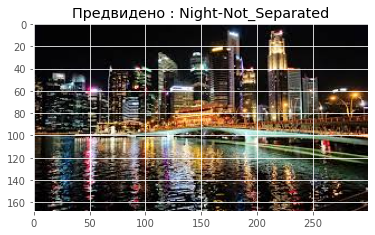

In [46]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUSEhMWFhUXGRgZGBgWFxogGhkaGhgYIBgYGhsYHSghHRolGx0XITEhJSkrLi4uGh8zODMtNygtLisBCgoKDg0OGxAQGy8mICUvLS8tLS8tLTUrLS0tLy0tLS0tLy8tKy0tLS0tLS0tLi0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAKgBLAMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAFAAIDBAYBBwj/xABAEAACAQMDAgQEBAQDBwMFAAABAhEDEiEABDEFQQYTIlEyYXGBI0KRsRRSocEH0fAVJDNicoLhQ2OiFheSssL/xAAZAQADAQEBAAAAAAAAAAAAAAAAAgMBBAX/xAAwEQACAgECAwYFBAMBAAAAAAAAAQIRAxIhBDFBEyJRYXGRMoGhsfAUwdHhI1LxM//aAAwDAQACEQMRAD8A8Q0tLS1rAWlpaWsAWlpaWgBa7paWgBaWlpaAFpaWu6AOa7paWgBaQ13S0ALS0tdjQAtKNdjXY0AcjU+027VGCKCWOAB31GF0V8OEruKRjhu/31thRw9FqBbipH1B0Nq04Ma+gE8VUa6GnX29J2zwLTJHPse2vCOqEea8dmYfoTqrlBrYmlJPcpHXNd1zUyhNtts9Q200Z25hVJMe8Dtxq3sei16t/l02by1LPH5VHJPsNFvBQdTWqrTqGFVFZRgMalMlTiCSgP8AqNb/AKn1mttKZpUaO3ptUHlNYvDMOLj2z/Kp76jLJUqZfHjTVuzxuosGNM1Y39Nldkf4lJBgzkc5HOq+q2QOaWlpaAOaWu65oAWlpaWgBaWlpa0Buu6WlrAOa7paWgBaWu6UaAOaWuxpaAFGlpa7rAOaWuxrsaAOa6NKNOC+2gBsa7GvRP8A7d/xCA7O64KCVIm4lA2WLexGVBGRjWG6h0+pQc06qMjryrCCP9Z/TQnYFSNOA12NXOlUFeqge6y5b7BLBJFxUe8THz1oFO3UlFJIGt31ja9Mai67ba7tKszTqM0qRPDgtAJzwOYzzrJtsHpgORGcTweR2PvrJctgi7Nj0f8Aww39dQ/lCmrAEGowXB4Mc/01ToeGK1LqB2ir5tRInyzIItDEiYmAf6aFbjxXvKi21NxUIAgC724x7RqttaNYW7kFrQ6guG4Yn4TwciePfXJCOW+9+fRHQ3Dp+fU267VqW5UNyWYEfylZBH1nXmvUR+NVH/uP/wDsdej7a6rudnSSCzq/LECVEkC4SSc86wHW9q9OvVDqVJqVYnvFV1P/AMlYfbXVGDW/Qnkkn3eoP1wDT40o0xM9V/wgok7eqyqjf7wgIdZFtgJMfYa9C8RdKfy6xplrjaT6VYBhBBUEGBrz3/Czfnb7RygDPU3CMJ4CqpUgmeSZ4n561NXxxuWrVqISmosxCklTnPOeNeXnVzkzsx3So8W8Y0bN7uVPIqt/50F1pfHrh95UqhSvm2uVJmCVAOYEzE8d9ZyNehjdwRzTXeY3XNPjSjTiDNLXY1zQAtc13S0ALXNdjSjWgN0tPqUyphhB9tNGgBa7Gth4e/w+3O8RHpPS9a3BWLAxMfykaqeKfBe52Fv8QoFxgQZ9/l8joAzUaWrNHZM4JUYGnV+nVUW9kIX37feOPvraAqRpadGlGigH0dszh2VSQguY+wkCT9yBqPR/w9vjQ2+7YIreYqUCWMWrUFQkqPzEFVMDQ9NkrBmUkhQCZV5iJPwqygSDkkcdtK3RqVlEauUunVGW9UYqOSATqTc9PsUH1XEiFKsJBEz6lE/b2Otd/h31qoiVNvTr+V5gkkuoBKzAMgHOZKtx9NZKSSs1JJrVyMVX2FRFWo1NgjZVyptP0bjUSNGdejdJ3++QWbWrT3VDgbeqabm0yThTcv1ELnuQRrEeJWB3FQrQG34mkDIU2iYMDB5j56Iyskm7a6eJ7LU6q1ZadWVWxFUeW4tGPTAAHqnsR2idZvxFs03VyVEtrDIYZb/uwbQf5ZzqzuOsHbbe+mq1HISGZQpS0GSwKEOuQIgfXWUbrzMPVSQSSfRNoyZNrDnnJaPlqVNux62MvuKBRmRuVMHRHw8jtUK0yAzCAS1o5Hcf21W6ms1Gb3M/tq/4X68+xqmvTRHqBSEvmEYkeuARJABET31dCs2fh7wxuq9RKTFFmSVYPOBMEnvP9tVPGfSP4cLSgQIEicMGyDPfB+2udK8Z7gG/+OIIZmNm3LZbnNokH2PGo+p+IK1dFWoUYF2mqphyTBKurFY5iYH31i62TWrUn7mFqrBI9if9dv21PQgMvvI9p5/XS39O2ow+f0/e39tOTLCM5HBB7j2c/tpTpRqfEVJx/D1UYKVuX4wHloi1Sbm4MkDGJiRqh4up1W2+0rVZJPm059lTymQfo5P30V6qaRrbJncIlzn1fCBap9TY+Q+HM9tXqHSnr0KdHbsm4AreawEkIKgEIwEA+kSZIwY54btFHVfh+5TRqPOPIYLdabeJgxPtPvqPXrnW+l7iv02oEpbenQRmq/hU7QrUyVcYZpJt5xryKdThkU1sLkgovY9g/wALNh5myUwDFZR+tQ8/vrVbbokb3cY/9NTxnJ/y1554K8UVdvsRSo2KfMZyxW5jaxbAIIGJ5B+2qO78Wb8VTVO7enVdWDGIuUGaa2xHBBGPf3zy5OHcpN3zLRyUkQ/4n9ONKtQMfFQpnA72jn56xRGvRuk+JN3XRzVruSopAFREqA4E2L6u+T886r7yjeXdi5ZgZLCJx82/tq2HXFKLQmXs3unv6GB0o04IbQ3aY+8D/X66bGughQ0jSjTiNcjWmDY0tOt123WAM0tOI0gNaBer7IRdeqrasErU9TEepVlZJBEHt841B0/bl2MKrQD6WMTjB+xg60nS97Uak9SqQ1JWpJYcJAVizBZEsFXgA3ffWYNI1GcqoAmYHaWgAT8zpIt7pjSSNt0jqG/p7dlo0ZKEKrL6nWWkBaeQw7TB76i6pW3++oqKlMsoZWRoRRbawMvgHtyZGsrvOmVKUCsjU5HpleRJ4z769Gfx5Vq7dQ1NTTVfUebYC+nL5xHOc/fTqk9ybuu6QU+kf7P2Qq7hJNSooApOrsALZLRAAOQMnkTp+867t62yrUxQqq1gKMwWJzEwxMY0N6x4irbyqSyVLjIjyyCzL5fpVRyxKmF+3fVXZbgi+jU24otWCgFkamscGo5ckBcglhAyffVk0JDG3JazNptCRxqCpRI17V4T6PshS/3qAfylGR1ZYHqDKTyZ+2sr4v6Rtz5rbYVWhrVIUEGBJBhpHpkzb2/TGlVpndxGGOOWlO/sYtVjbKxGPPaTjtTS3B+rdiP7lKZqkVbRN1OqKgFJFW1VT1AMQF9WTZkRxkDVGkxFGkAwX/eKh49XwUMgweJ4Py1fG23FQFl895aoKjKrFWgIFBZQQZzM4gfPXPlpPcnjQzrXT6iUiK7PKInl31DB9T8U6nqAtmAvBHsdLoNZqFKpUD1FkQQtNXUg2kyGi0wB6pxqfxfSqGqi1pp/hhiWy0hnAuwoGDERAx9NVtt4w3K7RtirKtJz6iF9RBVFK/MQiniccwY0j3itPzN0xcmpOgpUqX7cMGq2s4sNQFKDMpn0MEWHwRIP5YjWS6oreY93Jzl78EY9XfEaI06gNOqrqxY2+WwQKsTlioAJOAATOLh7aG1NsQCGBB7SCB3nkfT6Z00dibhpS35m+8VbgHbUVLAe7KPWQKRhWQhe+Zu1j+n0izryRnH2Otz4n3Qr0KG28wVHsVkVVIglGFvMN3HI1e8I9W23T6dShUQ/xnnFXamwFqBVhbyGWLrhC8xzp8a2t8glF6U/ExG56STkAgdxHvHefrqtW6Q/5VLHsAD+2va9n4u28y9NqgjhzSYdsiKYM6n6p1/ZGlV/3dVNpAIp02tIHIiJHz1spw6MRRfU8h2HQ9wgILqsgQhqZ+sD0gduZ11KFWiKdGrSC+sv5h7FmAK3AhZ9IM3cEcaCgs7EhiTIiSe5jB7c/LR/oe5qtWopUPoDqjuGbJV5Nzhj6gomRHpAxidT3vcomlyBHVttFdl+EXDJkDIGfyY/1nnSr7QqpYVUNpXAcmZYfCLmmP7HRrxbtk/jajUM0/QQVB/lWYIpywn80mdB9+htOGiRyrxyO7U4/ro6mrlYU8buPLoRxJ5MmLEPMn99GPA+8221p+ZuNw1PzPXbTWpc0rxCAgqCCAexuGhXjl7qdBiAYfI4n0KSPScTnjjQej06pKTSZg6FqaSzegzbFuSPlj6Z0ZYqcWmMpOMtj0Lq3V+lvSKU6tX1CrgowUXK9sie7ED4Tz25146NHd5sGQSyMoMgSpHtIyNAyNTwwUVsZkk5czTdAqRQgCfU/BjEAn7AST8geNUuqsGg+sm9hLkE4iRjtPHsABq54dozt3b+V4iGPZMkgWjJxJme2qe/BYuxmTVc/wD5PPbHfVZAuQQ8MEkVQSTApgTOBNTHPEnjjOjO2UEwAM/If+f30P8AD20ak1UVCqC1DLQ4OWgelo/rovsqqGqgmmQSoFqPz8vbJ7+2sTJy2AvTqanb0wFpgsgDXLgkEAFgoM+3E6d1600mK0NtSinBNBHUk4Mtf9O39dWOj0BYqvIi8G2Jhav39tXvEuxprSq+WSy2tDMRcZU8qrG3vzrdW9DbtXZ5zroXT0TWl8L9K2tVmO7rtRRVkWpczmQLQOxzPHvxzobMpmZFPXfL1v8ApLdJQ1BXpbmoLz5ZDKDZ+W4YF3vGNDtn4fbc1D5KkKSbQcmO331PJmhBXJlIYpTdJGQKabbrZda8H1tuPWsfLvrNNQ+Wsx54TVxdmzwyhzH0KlWi9wVQsrN9LE2khgpFwESZEZHyGhu2rMpJVmU/8pI78Eg/56P7ncUCSjsh/Et/CAQ+WFJuDNKj1YyTxxoHtVYyAMAySSQAe05tHHfVouyUti3R2lSqjVSC+bZa/mCZvwsgdi0/8p7WK+z2qr6xXRoYD10qgu/L8MGI5x9/eaq9i0y1NGBMGp66i5XiKj2ipEHt2jGTT3ewp3lEcTJBNQ00C8cRUbGf35gxpM50ZB5yilUhrlguAAT/AFAg++iG8FSnUK+cinsPMJuntwYEdzA41Ltt3WpVKb11pOFaVKiiQYm6WQSTxE5HbS3PiRGqFvJFM2hR5LFDBBBuYZI+UHGNFsy9zSdO65SqLSp1V3pqeWixSqlULcEKlNgo9+AT30Ho72k6V6TValKdxeGqUy7KqqwAcfEWnBn2zoPQfblrnO4QA3SERw0ZgA2ge8mR8tQ0/LuYqagp+b6JCs8QbbhKr9YI0pW7CPVunW0aSKUqs1arY1IqVNwowDHwsfTCsP7aW42lRG3AqKXhapB9DMGVgGY2yVHqyYGYyNWa27SpQp+bUCClVemllMglT5BYXMSEgFhn3+WqVSrY1ewg06i1AowxtVwBaQ/pJ5DEHtEzpJN2PHkHNz0UK9NbUrlaVMtU86vZkTaAhLg+5X0z2Gl1vw+qUHrUdkUKqHFSN5CgfEV8xbSIjJMaLUyBTABgAj8zhQYj46eabZzMg/fXeu7qp/COrbhvKtIgVdy5AlQQFdgpMHgmIOuhKKRzu27MAwIJNR2bgyomTAMYPaee0caL7DdruqKUHgOjGKrtNyszEhrjzBgEHt9w3pwqebTCU4bPppg3sAsZuIFx5wfzTq90lHLgFXq1V4V0sqg3CPMJDFgFj4iYFsYxrnnKkUUdUlZzxYAtanZcANugkgA3WvMQTjGDI4ONB/DZucOSfjgnJ/LjAB0R6humO4cGWBVZVmIECndEDIWSxxxONUvDFVmqgkeYzOPjF1xKxwSJOff20OVRZSN7I2dJlPpJJXOAjqx4j1wYz/f30/f1FNN08p4N4Esp9Rj3+2f9B1cNRIL0KFJ1EklAhUHAPpfDEg5+eq7dWoA3VF27Bg0iXMkjJJRpuNo9pga87tOqOxYJtXRmtn4WqlPVUoqTAAL5yO/px2Gn9O6LXoblb0BIaMENHMzMEECSDiCMEHOtW3iENT8qhtgVAgLR27MQPUZDPJDT3Bn1ad07bbirUAO0rhGZQXqkUzBIyQ0mbZxnVP1U1d8jf0ca5187AXV6KGpcaKvBEu7TPGMCp+sk6o9UWkablaFFYzckyMju1MfuOdaLznbceQCgsaPgZgzKTJyw9uNM3nSa9Svix6N4vby2tIHuoFvxA4nMTrYZ99/uE8CSpMBeM4NGj3/EPef/AEl+Z1zp+yq1U29Omzl3XgGFALYXnmPeMk/UlfGfTmMUzAZHM2rAACi5ok4ChjPy1Y6D0L+JoK9NxT8pDIZv0gRMxEkTOuh8RHspO/yyXYvWBd/0hlZkBm2ASRBnuIBPee+saVzr1rwXQFR6oKkkCSRUjj/tPPqz8/1CJ07b+lXCU0YElxTuMg4MAgmR++jh5arT6EcsVYE8NqxpOMlQ5YjMD0qJPYcxPzA1YpdLdvNSDisOOPjpz/Q60XhPYpTqVkeh8LfCxIDSotdY7EEMIJ13b0rKlVo9XnR9fRTeBJzjP6/KUzZmrSK4oJ1YzbeHnptVEFb1pgZP84HI+umdIRL6ZYOWNRQDebeRJtKngFe/ftr0LqFerXqmkLSKdK8Z4COpjHMxH6aw23rUFr0EYAWuTh85qkYHf4RpeEnKcE5CcQoxboF7SgQ1RByr7lY+lV9N6hX9DpABKlTE+oxybic/SBp2/aytupjFfdjP/XUOqe3AaL2QCDIAIaB9ozjvrqk9zngrRntrtWvsKOSCZVVlsc41vundQ2lLbNTqbc+ccAnsfmI50H8aHZ/gtti5JpKGYjLOsrPzMgA/TWTbdMe7QOASfT8hPGubNh7VK2dWLL2bdIN1aBqEtSHzC+4HJX3IGY9uJ0d8O9bq7a5wrLYt0EMJJZFXkZ+NTrFpvHm4VHDDuGPYzzPMx+g1rd3sKjGtaVmpt9vXySEUPa75YwqhlIHAwBqOfHFrRLr/ACi2LJ1QdXf7jqjmlaC1TCuxPpYCRODgkRxIn7axe/6PWpuVZYI51N0rxpV2jBqTqIFptuzECTPM541d6t4i2r1qhYb0tcwY+ZRiQTMTS412cPw8IquRDLllLcye1qqKvmgoi3VAJzyhthFhszF2ACRxB0zpGzLXVWDLSX0llAMMxELlhyJHP66sbTonmBx5i03SZFYooMKxMS3qOCBA9s6k6XuK23uWkaLE5uspswkcXOpIx+X5nVYyjbOeUZJIm3e4SigahVqCoWjKrbZBM/ETcGAPt+mRdcqSt5gMZYqBgE5IGjvUupgBJppUc5tqO1gBUcBKoA4jgfTVVKqsWFm0NySFJgUsnAMEHmILE8QcHTWTao50vc12KhHdrJKWhQw5khoxg+/fVetTdFdXSogci65IEi4qFxg8Y9tT9I3K0gSQA5IKvScBgZiB7E84IEaIbqtS3F6rQdqtyPe1SirlCOCzDmY9InAHGt2F3vkH+ndR3f8AD0aP8PVanYMlqMFQqWxfIXETP07ax9DbIUa5Xg1nChShYED0ySQpAnJGpKe12ofy64rI6xIpJSaSQO7VefpIOtt1XaLt9uqLVQU/LpStXb7cvlgjM5amW+EACf5YkxGuaU1D5nTjhrdGP3tGNpStRrkr1FLMRcCqUYKx8IJPALAWjOqjlmL3VKmFqSLmjNQXD4SLScnsSMmca9creHdxUrUdsDRQNLlqu1pOYKjIQUgqtCKJNvw8GMZHxN1zc0t5WoOyVfJYUgzUgbQCPUigekxJ/WD31NZZS30/X+h1jS2sI7bZlqdN6RerNNWBVKqsBAIF9EG4QeCs886q+I9sF2rX1QrOD6Klbcg8yQVdBJ+Ud9WfENes23p1KVUuiqGqX0qsBg7EL8TC3jBPAGMmQ7eJt35lFKIDX+pVRawvhySpS4hoUZAmBoXEzkh+wxrqZnZjyzd5dOrz6X9S5AyQCMjWq2i1iibhr6HmekGldDKAFKqB6isAA5P9tG+mMoNav/DKlY0ldLRSWX9Qe3JUTkQVLGBkTOq48Letqm5840VqHygCMzDXScBQQQQBJ/fmnxVtrkkWhwqW/Ux/UqZ8xqlwJhVZTddmiMn028yOZxxq14Q2gD/ihiSJUg/AbPQSD7DtI7Z1oulbFKTMpANKq3rBUN6eSpYSZLWZgxH10QbzfMUbeAqhAVVCQ6p5cB/uLoGJY451mTidS0R6lMfDqL1S+6C+z6ZtazgvtvNciDUakArR+b1XwIj/AM6JuvkylPbKFDYIZQs5AiFQ5iOc6DUtluPJ8uNwCVjCkUx6SCAAAfbv7n21eY1CAKtBmgLk1QDKgZ+IR+aPrrj7HM3ydejovPLw8X8S9/7QRdq5BmlTVxIEkkQbrpmoR/TiflqF6W49TXUQAGPwoJIUHkIGBzj1e2s/vTkh1pqrkGpc4uI+TF2AzniOcZ1xd3WCWtVoqLgZV4JAnBDLE57fbGtjwmXnQi4vh11X3/c4OrVat4SoLypUC6Ag9XqW3IKyc8wx99ZPe9JqKz/xG6qXvDA+pmqGYGQ04UcH2xxrY7ZqhZStW+AQQGpFTPES3bP1nOn7jpG4dg7BiwOCrUgO4BhakfCYyDrox480G6Tr6mviuGlva99jz6p05/LMy1ZwRJA9UeYBBnLZYMx9ue5IeEutAjy6iGo1JWI8uoQWUQIJyCZKwQREa1e48L1qg9YqEAMoCouFacAUlNogjjsNU9v4UNG5ko1Q1pA/3V84OCRR4m3835dXeSelpxft/RD/ABau7NV6l7wx4pp1t/uFUMAaZZR57GRAMLmIEjjGMazviHagU6ZZ0LkUyQXEi51gnMz9ffU206C9NxVEU2mI8kIxU3KVFyyoA4HcRqT/AGdTo1CalSkiuDANRV4qApFzZ9Mg/KBrY5dE265k3gUltLl+eJb8M9UD74tWcWmnTEmMBYUBR3iBx7nVbxpv0WtW8oF1Xc02hMMZ29PIgGPUvtyNO3fQR5bLTYljTlCziDNxVsYInuMHH11X3nRKqIpFN2eV8y0TcDAcRcCDZLDGIPGp61KVs1Y0vH2/s03VN+lGuKo9V1J09MmCHp2i1Qckk5/5T89ZCvvGFZWK0oDQXZEFv4j4yIE8zzpi7OooRlpVQRFztRdkcBiCig4JIhgIyNQdR2ddAStEks4JlSRTAEXMY5JYQeOfbTYe4lG1sE4xlez39B3W92jVtw1IoQ253DFiRFr3WAjmJkkRP6aBChUFQMxpwrgtbAj1AHCgQARx79tHt1s1Mn+dpa5VySDDGR3JI0LczcZXK+YcdjByQPVzM/5at2jZFY4JcmSVqdoplSvoWvaRdClkLIZj53Y9tAKmzJAZq/pZiMLOREnJE/EMnRBTUIqMLZQXAAn1JjI4xBzPYD31WrncKD5iOjYhSCCbisYjuJPzjTR1eI8tPh9RtLZGm7or3Fb5wv5QZgmc4xol/GltuUdWP4abfETYtXzVJwYjKz9NUzRa5VZxmDK5xcyn7yOPpqhvrqbEciYBIEkRIP6EaHHXVmKSjdIs1Ok01RWFzEiSC3wifZVHse/cam3myptUc2q3qPqubPzw3fVEpNkFCzkCIAtniT89R1abKYZVB/7T3Pz9501PxDWukQvuOoLVZ3fa03JGZNQwBxEvIH01Wp7ijWi7bU1AJ+EuOe2DxquSQrfQzzqrsTpowX42Rlka/wCI1ex6Nt2WVo0zIIyz+3MF+dU6nTkUn/d6I5iWfk44NTRHorUyEDEqckEH95ERqhUNG8qqGRg+rBzzgcmdUxY1KVO/dnPkyySvb2Rd6SKTVD52yRlhiV21MFzAOQGJAUcn2Htox1OhR3Dfi7fqhuJYeZ/DQuIwXQkKAAOeEP8ALgR4a3Nu4dqa2nyqq4wYiD99aHfdbrFZNWJVxzki+tMzgYJz89Zkgoz7pTDk1LvHdl4P265Gx3lT1wUZ9nmFuPqFNYXhSQwzcOdEqniEoxUbLegsGhVO2LgK8GIRiALogzk9ta7w9v8A8H1tcIPxHH5uMfXJxrPVuoMzvUpuoLXAWjABaTHuee+TqebSoKTOueLTkcI9CDofXtw+4puuw31V1BZPOakqi5IJJ8tBADEgE/m1zqvUazVnqHo9erVJgln9PpLqALqcW+puMG460Hh2s43VIGoSPL9xmEWBz7aE9R37GvVisxC3GIXB81pk/wBtRclp5EleoC7LfMz1Kj7Ftm7osVTbUuANouD0jAERAjt8oI9UbyGp1KNI1KhDKGoutIqAB3cAAG9hC+x0X6si20gJH4NKcrmRM8fTS66LKI4EDLN2z7xj/XGqYYKV7chctqqfMymxobkAqvSyUckm/fIAx7lvWAeP6DRd629VUnpdEjEB92jRjH80ateCHDGuzMTBABuPHlSQPuZx8tS76unk7a1icODDQTDd4H9O2uOPFp5dFL28rKywNR3bfzf8lnpu93rKzjpm29OPTuKdxMTiaY7fPWk8VbutRoO+3QVHHl2Uy1oJd1UyTgAAk/00C6Z1NRRyWPqYfEf5O576LUd4Kj1Ac+gRMniOJ16ztYtZ5ulOemjzSn4o37mr5qFWQGEp0WtuBIPq9ZgHvP276z/W+r7msoDUq9JwqCVWuFPJZ2uEyZWIgRODjXpO46SzswppTLEGLgBn5mP66f4u6ODa1kwirKsRFsj7rkdvrqUsiS3ZWMGn8KPF9zXfzKYqISimQ9RGkG6JUnMcGDHf5HVzr/iRXcKAFRbQLWBkAetiTkMT2jv8taPedO3C2+WwCmBxjmeY0zqFGtVrDy3CmBM8fOcGNJHNBxdMolLwMFU3C1HLAlUx6brjk8IJk/T+utJsE3lOga+3qTTCq5/3lWZQ3ANMGQR3FuNXupbur50UzSshcPSBk/Ue+mrSfk7bZMR/7BBx3+I/trLtcjJTp7pBjw3403FoqVSSpDYgAkgkCw+083fOO06rwX/iGN1uE29Sg9N2ugkgobVJ5wQce2sRsNhRdlFbYU4gwUYgfKPT+x99HfCHTNom7pvT2tSnUElWLll4PIv/ALaqsjVbHPNY/A9K3O9ZXCAMSeInP/nQ+r1wFzSJ/EEysrItEmQT21cp72Kgk05nuG/86wviLpdEb2vU/ibKrMSV/D7gYF5XBwee+ieVrcMGCEvifsXd9446erslV6VysQQacwymCMKcgiNU6/jPplxa+jcwEnyzJEQPVbnGst1TwadxXetTdIaCVWkGBjknyncyeTjOdDuueDahYsp29MH8pDUx/wDKkup9vGyi4eDvvcvM2Q8RdNqNKuly59DVFiO8KQNcrb/YlUDVnQH4D57iYJAjzJmDx8x8tee9O6BuqTOafktKssirTYZiYAaRxEx76qbjou+Clmolg3NqFuMfl0ykm9qDs1W0n7nqFSpRAKJvqiMD+Z6TENnkMvMTjUa03LT/ABausnBpUzgnIuU/aSDrxevt3Qw9Mr/1JH7jUnT9yVLRaCVImxSRxxP76yeOLXJexSCyX8b+57Uu3pgglKRhYIIOTPExhcnH09tUN7TcU18va0XbuoemoTnCFlJtBz298RqlselMOkUdwjLNJ3FVkPraavom3IhTBDZGNY7qXUN1R3b0jVq0wTIDENAIkczqCxQcqr6na1mhhWRTTvZqt1z/AI+prH2wK3P0xkAIBpUmVgQCWDei3E9p5I9tDA+0CslbZblc+gmk8IPTxFT4pBB5ER9NZ5PFm8TJcN9UH/8AMatUfHlaQGUEYkiQfn3Pz1TsPX3Obt8i6IKjddNIYO9RLgpKlHDBlBAAYBhEWjj399W6nTekVCX/AIxhJJjzSsSSYCmgCBnGg7eOVaRUpMR9VP76g/2/tGyaZHyKD+2seB9JMf8AVNrvRQIqVYRhmYIHGNU9m8fLOk7GMkx7jP8AfXNkT2S6MnBwOMx2B/1210JURe5suj7AsFlHZWBAIDARJkg3KG4nuBBxzqp/s9Q5DNUWzDX8x6rc9sjH10Y6I7mm17Cp6RYFapCq0wBTKyx+ImZGPkNB9ztCrsxYMCQIliQJ5Z7LVGPmc8Y1fh43Lc5uI22RD0ipbVaCBKEYEwCB89XKO4L1VpuJHAIGYZu8cLk/20LWspqSQog5+JpA4IJPB/0NSbXeUzUDG9UB9VrQ0HkCXGPppMiVs6OE+ONrr1PdulLS/hR5SgATaSzmSAeGIBBGZAGI/Xy3qXVXVytIlYwbiSJGGl2WckczzPvr0HpNOkdrFGpUVSseaq3F1VS5haojuxiIgcEa8o3ppU6jBfxkmQXtVmBaA0AEAH5mdLlSlBKjsz93PKtjT9J6tVG7pGLjFvpLRkDgkRPY/XtqnvnqCu1y2MWMoMlRMz6Se84n9tQ7XqDGtSam1sAiyqamcEH1hHKwT7gTHy1TpOVrkeZUuLEsQA8TkqrNn3GTzrmcSSe5vB1UVKiSMhFVcmGt7gW3cfL3zqx4k6pbtywBCgRdj0k9gOScgQO+s024eUJpkMQBJPOeSqVDDf8Abox4qo1W2yqA7sVBYLbIxgm5ruD+UTz3xrow7RYs92gR4R3wtqIIBgkmJbOACCAIMdjq91a1VoAEqULAIRCnJnN2AB2MnWU8P77D3VFstJYQxU+lu3M4AnmO3cWdu1tKhUtY02drF8uAirMwWDEHgfEcLEdz5Twf5dXn+x3ZMica8jT9PrqyFTi2oCw5AxHYm05nj21rthuFjPDIvqF2APnbb7cmc68oq9XBcpRLOyySaaBrBMT8Jgge0AmftpfD26uq1EEPdTW0kWkLLfzQQYHxi6eJlTHrtXgS9TiceUjebJheChg88EiJye2OPpOn+IVVwBJUk4PuInvx259/0CbKQ14MHMKMryTyVxA+o1Jud23lXuWom43KrqbsMAvwfEcHEHInsBx542nqQ2PnsU64V6XMevHEm0E45PcfroR0yrSpsWJYhmgLJBJAMGDiMnM99XDWim9hiLTFXODEySROfb240J2dVWenSNSkHkAKagLfMoAMk9ok514/Dxe66Hc6as5v9nTavUg/iMsWSptYsmQcf5/Foc1SahAkAGBdgkwJMEyMyQPpgavbzqCnc1JXL+hWgEqM5JLG4HEtj6ZOs5va1NahCD4ifiYEwZzBY54yDr0eH1XucnEQTRtOksxAvwfYRMRnkwRz+ka0fQadMuSD6lmAAOeCSQe3+esH0jflXXPpBN1sAxxxfIEEcd9aTwtvyKtQEO4QVJJ80EiYVSWXMyAYB7ntrsWRqzieBOtg/uqv4oIU88mP85jQbre0SrUJIkkzIAxjjtqj1zfla+XooQRAIlySTk2MsGOx1S3PVAxIZ6pPeQFXjgfaMyTq2zObTKL2Bm48NgVDaInMgGfryAOPfUFc7qkPw9xVUexZj/msffR/a9RD2i5ASqssupkGYOCRJAEH7nVWtuwxaYXgmbPYGTLGBHbtjOoyhFsdSmlbM5X8SbpYFRKVQAQbqSEn3JK5+Wp9l4mptSIq7VAQP/TuT9IMaO1+krUQEEANFogAEkkYYD3B7xoEekoobDAn3mT9iBA51kYR6G6v9kPXr+1j01N5RkflqXL+hOmVatGpld5t6ny3NEA/Qkr/AH1S33RQAcCccH+1pj6fPQDcdOIHIH1kT+q6R4kamnyPTBuGOxfaijSqgspVKNZbTBngMGAHsJHf5azXiLaI1RatfZ10No9VOpj0iOHpk/c6zdFgKdVb3DMFChMgwZMji2QhnnGmUet7ulFlapAwBJI+6mfpo7OXRnSsktGlMv7jZ7RkA86ukcX00bn/AKSv7aH1OhUz/wAPd0W/6w6H+oI/rq3/APV1cj8WnSqj3eks/qoB1G/Xdu3x7NR86dRh+gMjTLWiLbKx8M7g/AiVPnTq0z/S6f6agfoG7UwdrW+1Nj/UCNT1N1tmygrJ9bWH9IOox1BhgV3A+rf56e5hbKLwRkkfIA6k6VSDVBc7IoyzKpYqB3AH76iq0cXBZHuTH9JnUe1aDNgcD8pDR/8AAg/odVKXTNp0pdiElpLsGEs1NFEfmsZnctNpEhRg/TVd95SNMrQBCMTeCqtUwBceYUEAfLmO4CpbhRt/Mp09tm1CFQmouBLN5pURk8CCfzTJ1b3ao1Fmu9KFZYofUbfhQLCkYnByBg99X4dXas5uJe6tfwAaAC1CVBMci2IM4Ed+x+8fMy7Uu9UK4qWXZWmYYZyY4AJ5uI1DualVSbywVsgBokHuAufbnUOxr2VPRckg+q4gk8gwZBE9sfUanPmWw81Z7JvaIXpzXUVppTvcl1p1KuU/4i0y5XzOACzDA+2vIKYBBIV/kzKsQRjAVoP669K6XTU9OJXchKhFS7cLUKrGTzVUOxMWwrCSOYwfKdzufMe53aof5mYkkdpuYx2xOle6VHVxOrtG5c3+eL/PILUN4gZb7ahA+DyGcA+9j1FUntPsTpm3+ORTjtkWicZKoCQASIyYjI1RXeOpC02IP/IoUmR/MuT3zOcadRrEkFmLtd+aDz83B9u/11NoktjT0q7oRUqVqYYQIKuCAABPqqIeI9hjRzxNWpHauah857Qn4dWoAJFwBXzCpaIPc94OsM+8p0zKiXOSF8oqOIAIBEyM+kfTWq/2gf4RoliyqwLOhdSVF1ooU7oycm0i0CRnTdNjYu20zKUKqZZKlSgVkTaD6THJBWW+mecaWy6kAy3EgkQ1Qs3qXI/OW7YwAIH30qu4UAmLiZuDAg9vVhwWM/zT8xqm+8qE4VQJDBbAYgRP6RPAwNTSsacuSNj1CmbFN19E2xTDYJnAyhkACYzOcQNaPpVCstNFG4ZqNoY0sU7xdCQ/lhkwAeSeQCdYzfVlV1Y1SzfnUusKSItKMCIj5z2+etV4T62HpERLXMUQu0N6jkKEJ9MwQGEE8Rz04Ix0U2LP4LXOzW0UWkKbMgWoYF1Vqd6QCJHqLO3w94z240Q6jTWuLGa34WuKsqsVGVV4BPJ+Et9zoJ1DrQS1URUJEvBK5BypL1KZIDTzzONR192h25puzU5BttZhUBOVIdatUmJIF8mbTxnW5MaapEISd2wDvOsCiaoEox9MtTqlQTjLl7SIjMjnOhmw6gFqqtatTZh6bXuFpMQzKK3qHclvYYM6pdN6pWVKilKocqygVqxvaRcTb5RIIpkmSQMrofU2NJArbhKiO7C1SKjeYI5NRZzMC0Zz9tebDCk3t9jtWXarDHXOrOKuKbsCPUWWqhctwTgg44J/WNZ7dpVpuQ0EkD/h5MnspEz+pGpep1AzM4qOBAEVQ5uySQAQoCjGDOR88B6htYqQDHFhRcjgm24TquOFCznZoumdSZTTIZ6hB+H0yewBif1jHOj3gfdCjuAHWkqBiYuHpJMcVIX7CO5xrF0Lz6yrhQctgkn6kQDx20Y8Pva2DTKhSbKiUyzEDhJpn1EmQMDEToyR7svQ3HTaND/iHu6n8QrhqirYp+JvLYADMF4MYBXBEdsTjh1lPMe5uMqwHpnuAPbvhsmOdbXxBXp3QzOU9arIKwSAadpQEGEtw9oEzJnXle7i9oM5P74MxrcDuO4meCTPRel9U816AotdcQoRLsWMC7hZMG2DbaSc5MiGeLOoxXYu1gKqy2QpIIxcrK3rmVIPcHQfw5VJNIB2L3TFMBmCqOVDHyy+FlWznAIMaXVtz+K1RQYY/wDqKGdZETAqXDuxgYJMzrJf+nyBRXZ/M9C6ZtBV2Bro9R6gkP5kSZEwQAS55Ckj8xExnWb6pu/KqsEDupEi1Jw0YbjvP+XGr3h7fUhsKtQ2ETUElfWQVgClewggy1xkgdjI1luu7xHeKZFirakAhm9RJuJJl5Jkg2+0algbTa8x8+JOKZbPUEY+hVpnupvUEkDJWAIjTmqIc1LDBx619hIEnGO08nWcpbxosK3DiS5mPp7850Wah5af8T1kQAhJVhdEAtS9WPUOBjntrtirOF4ySknJZZDI0XEmMSCvqGZEd4E49xr7dW7H6lgeeIB99W9rWktc9NTSElqgkWtGArG0tmcLOecDUPT382aYr01EyC5VcRwPUJPaPmNTktI0YN7Io19qQSLT9Yx+0aqPt/bRXdVCpIabRxYIYjMOLySR9hzqFt9TMBT9Z5+/GhGNSToEGh8v10w0tF3tbJAHbB5/86pNTI7H5ac1MHuO8ifrp9CTgZ+UH+2oWae0fTTqTAGTPfgwePfTDm56N0+nSQvWoK4QQ1S8KsNICqGHqZsE3jGOO42r1AuXanTWkAYtFRnlyDJW1SCbRGIAAERA1Y8MbZKodGauU8sABqVZkUFiRAoZZJDZ9Ekz76p1umrSYUqz1KVRQFlWwbp9X4ltgg5Bjvp8WzEzy1c+nkCPNZhDEmBHzPzJIOn7CuEqAtkcEEjIPzZGA7dtRVKAUkyxWSFaMH75H6ah8yYnge0A/wBB/UjSvceD0tNG+8TDZ1NrTKVKNKp6RUHnh59JANm3TJEyPSsGffWE3LQ5yjQY9Ci0xiRgY+2jNU7M0D5NIvWtyr+Y1gE3Per01BHOUYazoaDrE9h8vxt3foW6lYNkKJk3BAAtv0A47ydXujVPWISc+zH9Qoz9o50P8xx2gRMcTnGD2nXKLSTKk8zawXH3B1jQt0XN0WNTFJVhota0ZnAOR+mtvTVqNFalfaNSWlLIrCnBJzCOTdmRkL7ycawVPZF2CoskjCob2HzbMADucRo7v+jCnSF7VWIEwrU2RYaCTbVIJAkQCIwDmdLKKa3L8PKab0q9n06fsQLWQh7YUEHA4Bj4fSQQOYgAZ4xGqHS9+aFdXSo1KCQXQXMFPMC5Tx8wfvquozdaIMgSV747mf6/fUX4jlaay5GFCjMkk4C5OZ0RjRLJLUa3qlYFaVQvaxQFw9JRTkAQVIcljmRwYXjVvoHVvLBWrQBL8WbmmgZDzeGktI+WR21VY1RQWpUIL3YvULLAqBcHBYthuAImeJ1MNkFl6lXbUmtl/NoIajem64Ju3mSIAsAWRAGDq2NOqJuXdo2e16zUkGjtaAS34f4l3YZOSlGmzAdoK88aubPqru583ZQM+qnSqEMABIbz6KY5kqDH8p155W6XQanC7trGDMA9faUqYZs5pU6tRhk8WiOMaDdJ6uwrjzqjOg9OatSwGIUmSfT9YGe0apKbbJqKW4Y2GyFarWrsKdEOzFU8gwOMLTIUQUkwGAE6A1drFQoYLcelgtrGLS14hVE5GI9xE6P7TcbFGr+b57GpgnbuUtQsPwxNy1abCMuwwvExqr4m6aiUqNenFNaoI8sWxaPhZmQ5cj4gBjiZ1zyT6lE0Bd6iCmoYW1AIhQIf1NLlgTPAA9+RjVejujaUn0mCZAJkexIlfsROiuz6buUprVpUwVqcPUWiQT2CmpnI7YmO8aGb8Vbj5qlWU2kFVUg/MAD9dTUlJ0qfzHppWdAwe/uYzq702oqkeYzFSRAgHuJBB+/HH709sjDsc4iOTOB+ui1GjWpsrVGK1CLgKl7GAbYxxjEGcH21bTcW0KppSSDfXUr1zCK9SkqZtRlkSIBDqTcDJjmD7GTh99TZT6ltngQB9sdx+utzR6sal9HyRSODhVKkyoURbKiCCBziPUTrHdcYiqQyuGGPxSSYHEA5Ud4k/XUMW2x051GlJDuk1WEhGC92BQNdwALSpJ+n10b6p5YKVDRrKQAGNNBTF1oBH/DVpJBMnGSB3OgXQqFZqg8hWJJCSASvq5DwD6Ymdavf7OjTsNS1KqeXcVqP8BWBYykGItEESuBJ75NpSJwvSQ9C3hp1WUUnpq8lwxZxUU8Ah1lTBm6RPHcRW6/VYZVWsebPhgAEi0Ny4GRJgiI1LvBEV6TugSQrrL+ZIAyxaI7GRniDoXvNwWpqr1qptVbEvDLGRgKIXEc8g6WK3s6HpeNqt/G9vt936Ap+fc+3J/bRnpQeqGRGFSoEdRTqtHlhSCCoY+sxMIAYzIwJDU3hhcrAAgmMNzmCRg+xjRqmgP4qF4qGD5tKk4W5jAV6zeoyGBqQM8xqzbXI5Yq+ZPsK1Kx03TPTf0vN4EgQAiAUWZSQw4LDEwLdV+jhqxqRaoRC7M7MsqDAF6J8RkAEwO3fVCu9JCoe6rFvpFUFRj1gMqxluImIMzzrnResvtagq0CUqqZR5BtBDBgVIIaQecRGiatbBCk9y31zeV9wVr1Fspn0U7ptCoFUKoiMAKCVUAkHQ96xAyysPkf8xqfqHUq+5JatXZgWLEM5IuJkkIOD9hqsoRexY/8AMYH6DJ/UayCpUE93ZJQ3R4Uc4iJn5CF1oenbDYGmp3FatTqmblQ0SoyYi8gjEYzoBRepUNlMf9qAL8sxz9z31HS2dVhKU3Ye6iR+o1tmJIpkfrqbZVKYYmqhdYOFa0ziDMH59tLS1ShEard16tSklSj0406dtquz1Srqs+7ANGeMc450G6lt7x5rPtaeAPKpYYQP5VBz9Tz30tLSoJcwXVKSQpYgSAYAn2x2GmU6RYgKCScAAEk/IRpaWtb6mxVtIlQIty1Fe7AEECwg+q5SstjtK51CI+elpa0GqZMlWyCM4xPAnmBqEnXdLWGsl2W6ak4deR78f67/AGGilKrSslKTAvcpF1UyBBwVMETEgg5HAxrulrGEZNJ0Dn2hz6SkfzYk/wDdEY07ptREe52qCMqaTQwbsZI4+n6jXNLQhE7RqOodQFdFvfzAPhUOHYwCfUqojKYmWkE9zqJ9xVZaq16MIUBUPWWgDGQxUmKpkggD2HOlpaZGVWwLodJoWq1XeUKciSFFV6meBaEsBH/UNG+kdL23qelv6rn1FkoItJoWCMPUBYZPCwIMkY0tLWpo1on6elTy7alDd1KAlooWNQNRWhma5ICXQSDABnHfVXxrTq+Vt2qbTyZRQ1QurPVqKoDtcWY2RBCgALMZxpaWlbtmIDdJ2zRVZKtZGQSPKUlT83qB1CASJYzE/bVPdpWPqqFzMepmkEAkCGmGEgiRpaWuSOR9o15pfSzpcFpT8rI6RM9wOV/tx+41arNWllLMe1sluSPbgcaWlr0IruNnM/iSO7TZmoCpR5UzNOkWIEHDQ4tH2++q/UdilM4q3g5U2OCfqGGO/c6WlqF7nVKCWNS/OZN0BUvF1V0YmFCQJnm5mIAHyPOeNazebWjcpqtSRbwYmoKRBm4FaS23TBwbvSBaBpaWpzjckLB1FjutbxHJ/hVDQM1Kb8yQSArVQxjj4VPuDjWb3O93MBWCCxLVNiXMrwQ1y5ZuDdPv7mVpaRJRlpOnEtUW7a9APXZyZbk/67aKpt1SkHrxUuFqKa1r0wA3qtAYWknAPtxmdLS1Z9DmapyKKrTE+lmxiWgAzzxJxjtphbsIA9h/nzpaWmJjQfbTQjMYEk+wBJ/prmloYJW6LC7SwzUYCPyiGb7j4R9z9tW95v1cj8FAAAoBLEwOJtYD+mlpayr3Y11sj//Z")

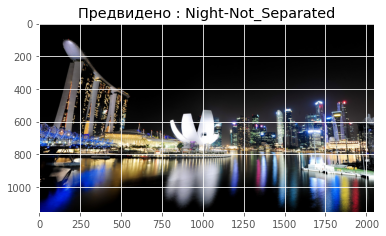

In [47]:
predict_url("https://cdn.theculturetrip.com/wp-content/uploads/2017/12/7871583332_d499fe286a_k.jpg")

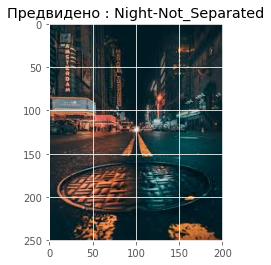

In [48]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMVFhUXGBoYFhcYFxoYGhgYGhUaFxgaGhggHSggGBslHRoXITEhJSkrLi4uGB8zODMtNygtLisBCgoKDg0OGxAQGy0lICUtLysyLi0rLy0tLS8tLS0tLSsvLy0tLS0vLTUtLy0vLS8tLS0tLy0tLS0vLS0tLS0tLf/AABEIAPsAyQMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAQIDBQYAB//EAEMQAAIBAgQDBQUFBgQFBQEAAAECEQADBBIhMQVBURMiYXGBBjKRobEjQsHR8FJicoLh8RQzQ5IVJFOi4lSDk7LCFv/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAyEQACAgECBAIKAgIDAQAAAAAAAQIRAyExBBJBYVGBBRMiMnGRodHh8LHBM0JSovEU/9oADAMBAAIRAxEAPwDyi22pzaHapE1bzGnrFMDR3WGumvUTRGFsZ7jqDECZ6agfjTmzIlZ1pNPU/WluW+6asrXCiWVDcAmTOUeMz3/L4+BoDG2iuYdCwnrDFfwoHuOjsNwViCdZp+MmDUXDTqfKjMV7uo0oX7wcacCqvDVvMU2ND5n6VJfGreYpsaHzP0pgnqD02pGQgAkGDt46xp6g/Co6IA6urq6qIdXV1dUIdXV1dUIKK6nKKci1ZBsUlS9nTSlQhHTmWKcq6iacFkxVNlpWNtJNK5qRxlmoKm5b0GgU/sj0ojD2diaN/wAC/UfGqcqLUGwbCpJFtufuN06elEYFwty7nOXQjnvnT8ifShsNe7NlaA6SCJ5fkauuHYxrd17ttAWzMBmAIgjXTMDNDLcLHTivEnwWLs9oWkSR7xJ0Go059NB1qu4o6wjDUEOfTtn1/XStbgOKM9m+z2LjPcmXRVCoLVoZI7x23Oo0PPaqLi3CVNtXt3LbgCGyE5kBMmUYAxJ3GmtJU7lqPeNxhpqVGCdZMDl0onFCUPlQ9mzlbQzpU+IbunbaaY1raFq+WmV2IGr/AMtdaSTET3tus6RUmI0Z/wCX5imm2QW5EGfiJB+Yor0AS1I1sge+Y3AG8/PaaguZddDPLb105VN2pLZjqdzOs0/FWSfu/dzadD9amz1ItVoAV1Pu2ipKsII3FMoxTVHV1dXVCHUopKcoqyD0FSKtdZ61KsaVRZwOlczaRA+dXHA+ENiC+T/TXM3gJ51Je4Z3soBJ02U/lSJZoqXKaYcNOUOZbGdUajzogrl1oxOHOczRAVm3093U0Fink6UxS5noLcXBag7maksWpNcic6OOFKFSZ7ykjoYaDHkQR6UTdaARi3qKyxAHLX5SPlFLr1qK5d1Pp9Kb/iD0FAkMbBORKbH3l6frrVhYzGSHI7x5A9Kr/e1HdbmOvl+VWGH3InofiNaOQvHdGu9ncdiEwt0p2TIhfPmDl2lATooIURpJgfCqji+CKWQ5w92zKwHBZkeRqDOokfvHyqTg12MPiftLilQDCZIbPFvWVLc9YI0qK/iba2iLVy6pKkNbuFSj9YIiD0kbga1lSak68TbJqUFfh2KTDjKQY5N/9CetHwGBB5j9a0K5BI21V9iDH2Z6VPaUQ2uhHmBKn8qa5ClDegPFjV/JfwpzqQXE9OXIpI+orsYNX/hT8KcpkvtuB/2/0ont+9hcd/3uV+wmrfCXc9xMradmqsVEmFGwEbyBVTb1OXrH15eNE8JEvBygahs0wFKkHYgk6x61WRWmXhdSSRBxQntDJBMLJG05BPzoSjOLEm6xaM0LMbTkE0HTI+6heX35fFnV1dXVYsUU9Nx500VIg1FWQLt2Psi0feAB+v4fOmqIqy4nay2kUbKqlvEtJH4nX9oVXLQJ2hklTQdg8dcXMEcKGTKZCiVzFokjeSfGol4hcWCrkEbEQCPWJrrCL3syMxjujUQ0iCefXSoAu1Dyxt6B880lq/mOu3mMliSSSfiZJjxqKzZLH60oBZo/Qqzs2Qo/lkfn+vCrk1FaAwTm9dgfGWgqCo7+IzEEDRVy+epP41JiiSonb8gJ+oodVny6VSXiHJ66DYnWmZ16URcPdPlQUUQtiuQdHEHkRz8/zorBsCTqdhPnQ1wMBBhhyb+tFcNt92ev9auQOPwNRwY4f/C3g4t9rJyl0J0KCIIQxrMajWgMTjEuWcr2bYMQtxBlYHlmE5WBO+k9KuvZzEXVwt7JZzoS8tnAImxB+zn7QAd4iDp0iazGKKi2pAg+UTr86zQVyf3N2V8sI14eA02srWxp7ryYj7jVKtsAEgiATp1y6kD4/KhVxGdkifdcRz/y2q1fCFV7OAYVjJ6ka8uWlXLTckKd1+6FXjlHf/hH1WKRnBLGP2R8EAn1ifWn4/R3/gT6imZdX9D8qb0M63/e4Dg2i4p8Rzjn5fKrbhqTdy5Fh+0GuugGY5hOugjcb1T4Y99dY9SOfhVrh5MojlGa4yoQSNZGhI1gjTbffwHKi+H3BPaC2e0zkEZxPw7pHyqro7iTvorvn0zAyTIYDWSJ2jegabBVFCcrubZ1dXVwogBy1NbG3nUaip7Y2qELrizZbSBoz3IuN4CIUeUZR6GgMA4W4jMSAGBJAkjy8asOJAtZFxhBuFMo6W1WF+Op9aqrZkhRvIA+lLXutDpP2kyx4hxIm4WtSg2GpkgSATO2hqHC4vYP3lXUITCnzI1/vTbHEwpJ7G23dygMGIB/bgnVvl4U22e6DAHKRufEzpQqCSqi3lbldjsIRLGOpgfL4URcU5c593RT1EAH8qFS5ofGenh0ovDOVGUiQ+6nwG/nUkn0Cx09GAHvTlB06/L1pliaLurlEJp56/Oh7FuBrRICW456hgVMwoHs28aICRMtoT3W0nVTuPSi+GnuetE3MGrG68E5EQBjzOQHMfNR/wBwoTh92E5fomhbtBRVM1ns6cQcPiOyyZUBaSmZsxtlWyHZT2YbU9QOdZ7FMeyEjTXUHxq29n7NhrZa7iWtMbhCqrx9wCfDVhr0VqobjnsxqN9RHlS8a9pj+IfsQf8AZDaDKRcWJBPrpWqwmPS9aZtRcVTI007p+X5VmcOdAZ5jf9aVYYnDK32iNlaNY0BEaipkSe5MLktgLF8zO6LPxBpLepb+X5AVHing/wAoj0p1nc/y/hTGtBS3AsMYuDXn1I5+FWeG/wA4oJntLoBG4YrCkCRqCAd6rC0OCOk8/wACKL4dczXlJ+856/eB001NDkWjfYmF1Ku6JPaAjOSohSoOXoA0LtIECPCqWrf2guSyQSQUBk7nvNrrrVTRYvdRXEf5GJTlFNpy0wSHcMwhuXEQbswUepirHiWGVWJtz2ZZghP3gsAmPOo+CYpLWdz7wRgn8TDLPoCT6VZ8cdDbw6WwYVCNRBJkSdOpk0qUtR8I+yBcXxHaKHXRVCIg66d4+OoiqgCj8YGKg7BYVR8ZNVy70UdgMm+o5lo1z3Ry2oQLNEM0gTtRMBdR2H39T9Jou6JKxyn8KDw8eXeMa+Aox50+fwoWtRkX7LIr7hRJoBcVS424SY5Ch8tEkKc3ehYUk1wGlNoRpc2+Dlhmt3VghpDEyMywdFBAMDqdh0rrPsvcCx2lrnuXHj+xVl7C5cl3eZU+sP8AgK0RaeYHnS1GX/L6DZThvy/UxZ9l7v8A1LH+9hynmtL/APzd2Iz2D4doPPpW2NpTEESf3vEeHnRWHtWspzKSSIHe2OkH6/Grqa/2+n5KXJL/AF/7fg84X2avdbR/91OY03PnTcTwy/aTMy9yILKQyg8gSCY3rf20y7x6a1wCm6ddcgBHUSd+RG+hqOE/FPy/JFPH4Nef4PMGjQH9kUuHUgkeWvqtaf2u4Gi22vouWIBC+5BaJgmV15CR5VmcE+p9B8StTWtSaN6AZHfHTLRXCbZzjKe8c2WJBDdm0ctNY8vCh73cZTOkfL+xozgqzcQRI7wMSdChUkgQY1/vsZP3X8Csdc6XcX2qjtBGogx/vbwqkq99qAxdc3vQ0/8Ayv8AXfyI3qlY/Krxe4iuI/ysZThSU5FpogkVq3nsjw5cUyZoAtDXXfY/hWQv4G4gAZSNM3LbUz8AfgehrT+zaMli4yEBlVs4nUy4UfSsvEaw0Z0PR6rNUl+oE9pUFtmQAEBpLRtMwo+dZk8vX61oOLX/ALJUY9/NLDnudTpppA9Kp2KjxPy3o8FqGoHHU8rr/wA7DsOg+9tvHXXapcY4JGUgQNvKaDu3JGu9ScNa2Hm4GIHIDfwOoI8x89qbT3MrkloSWmA1O8/hWpsYbD21DPcD3PeCoyMCBqIBHfMgqUMe9IkCaouI8RW4FVbSoqxkMsWAPeYe8QQSecmp+DXlS475SWVCVjSDB1mdOXIyJ2MGo0ApVGiv4rdV7pK2zamSyzIzbmBAyjwoOzEaj7w+HMVa8atHtBcIYF5JJEDYbfHqarsNJUqEzEsDoDOgOnlrJ8hUbLhVX8SxxXEkZRbS3AUypaMyz7yyIzCeZ105UFNBvcMzXZ6lFqR6D7I8ONu3nYKRcCGO0K7A7909Zq/hDva8/tD+QrM4XHXDhWAAAt5BmBYNqB0843GhpmE4riBoWnkCwI8fGudJ5rbujtQxcO4pVfl1NRktf9I//KPL+tKtm1/039Lq/nWRvYzFO02ydB3gQBqPdhXHidhQj43GE5e0EjkHsg/CQaNPM/8AZfMVKHDxfuP5G/tW7Y/07no6VE+E+07QJdEDKfdcRP7KnN6xFYd8ZjUIUnvEBgD2RMagEfA1c4bit5CMlpFBMtpE7agDSd6GTzRfvBxx4JrSLXxQd7UsGwdwCG1WY1iHBM8xWE4fh5Yx0G/mCPWt/gMS2LFy3iLanIFIbKyzrtm5jTl0NMXgeHX/AE+n3m6+fSilxLqpLUPD6MbSlF6GBt20gZyQukwATEETv1y/Gj+FIiPmtRdB7rWmQ5jbMFj02B10iBWlPBcNOU2hIgHVvz6j5VXcR4S2GuLdsMTGZMhEiDmnXmNSYPTc0cM8W61QrP6PzY43Sfw3/oyhwzMpZVJRZliANtTzMRVe1eh4TBm9YVZysyFWJA96GEkDnGUfCsHiMOV8jsfrWuMkzlSg4/Ov4+4OoojDrr8fpUIFWHA/85JA1Ma7a6TRC3roab2owoBmQrG2sKBqfsiSSeWzjx1peDWwlrE5GBBS0Qfd/wBWJHhHzqP2oQdqGAgZEUgSNcjLrPiCJ8KP4RwjECzezWnBdFCDI0mLitG0RANZ5Q5sart/Jtx51j4h33/hmbvWBD3B1VdNBBGwnXkN6qr51gcp+tXeKsplckt2uYZidQqaDUxqST8qA4hZiANQYKnQkggkT4+FPSoxTycztA+Hwj3NEUnf9E8q0GC9i77rIHTeQvjqfwBp3BeOJhkVWsQ+pzlZJ1MQCREUdf8AaxbikfaseUsFUdNAIPLQg1KlegtyjWq1F4f7HC4mdXZUgd+4DbHmAy6j9TQ3EsGuGU3MPd7QH7O4yqzJry7TKFnXrO1Le44wGVextj7oCh2Hq0yfSqrGYkX3AzNcaYHSTGwAjlyFTlfVhc97IH4vxZr4QsPckbzyHgOlA4fGlFgKkzOYjvD1nbwpLy5TI2IocrUpB3LqOxN4uZIA8hH6NRTXGkirIW3aQpUONY1UtmJ/DTlMULibYJGXXoNz6mjMFjrYnOo3mJJ5UFduBy3IanTzihSDb6E1u2MoOhcMCSfLYeFWuFvi6qW7umUjLoXMhh4FtddJO/gBVPhw52EwNeX1qRGMgNIOpX+IbeevKglFMZjySjrX5NtwfGq4uqjMmW6iqA2TQZg0EgwZIPga0GHBSyb/AG91gWlMzyMpYamRpoTtFYuzwfENmC3LYzvnIk5p35c6trmDxpsNZuXLZWBAIyxBnoMwgRXPnXSR2ItveOpbHHSwD4h2kaAXAGLA6gAqZ5TsBpvUlvC2rin7S93cuouqwM8gcomJj+1ZDDcKKshMSpYkyTqbaqh1AOjAmPGktYR7dsIWzCWJAYR3gR+XKqaXSQ6DlWsPq+35DMRjbFtpL4nXLHeSTuIJ571YniVi4iHOHcFsqNC3AcrAMchAjzXnWSu8PZ2QSAARJ1JEDpzG1X3ELWHVbUMVKmWKJBaFgb89jJ+GuhyUdPEXBz9p1S7vuAcTwty0RnS3cQklHuPoyHVADnGkSQPOmi0AqXLthCoJ0BbvDYAd7XXXltpQ3FeJO4Rc6tbUQoZZOxEnxjoaLwPGJVUvsXRCOzAAXLuG22MHSNqa+ar+5lXIpOn/AAUx4HfaWW05G+ikwIn6URYwqC6AiOyq3enunZZDHZRmkToRr4V6fgfa3BW8I1sKzNkOaTmYgKJ1O5E/KvPbfF0BKrb7h1PeYFmLAknUiIERHzpsckmZp4oLzNR/wvtMiAKhTMGUlrgCwQYP3nBcETsQegnQv7TAKNHJJygdmBBGne78LrzJ5HpWBxHGGdYVQCSDmLXDBBmdWJJgsNTznrUD8Mvs3adtaG4jLlhTMgDKBME9POjhbXtCc0UpPk+hZjhlq5cd9ra5VKZC4zEBpY9qCR+9rqToNKma7hbTvlVVJQZANyNSQB0JH0rJ3EvIxOcEEjnExEbHwGkxTFx1xY2YhVWSY0UQu2ugMU2zLyU9VQbx62L11CpKZtBKyJ3IkcxPKR0Jpl/hH+HS52jIzEDsyrTqLihwV3Byk7jr0oQ8QvT3QsFs2p3PU6/oVHiGe64LALMknMTr4yatXWoMnBPR6AYYSI6/lSWrxXUaGQekb1P/AITbXbwNILRBWdgROh2Bq2XGSexEHkQabhguaHnLImN4nWPGieKqpuubZ7hMiRl05aULlNC9UMWjIr5GYxOWTE7xynxio6kNs0nZGoiPcOWx4D4VKmC8B8qQXacLxpT5jSlHqT28CPD40YmGRea1XZj1NcDQNN9RsZRWyL/C4u2sTHnB+m1GPxxIgID/ACj8qzVtZ2ovsIMRJ8NtppMscepphml0Db3F2+6BHr9KFfHseRHl/akKaxAPWIpOz8fSaHliugznm+oP3jux+NK9jqaI+H69aS4y9aJPUW4qtQK4oqIKWIVdyYFEXSOtXHs3w0wb5MDZdCdN56cutHPIoR5mJx4nknyoBw9w2sXYtkjQqrDcd/Q/IiofaLhZw96B7jjMnhrqvp+Iqvv4r7U3P38wPkdPpXpPtBwsYiwVzDMO8hO0xsTyBBil5MnqZwctmqf75hwxriMeSMd4u19vkjz2xiCNjVxb4k2WCRtz5/KqASDG0bg8utTB66KimcSWVofiLk0KRUjmmUSQp5GyS3EiRpzCmD8TNWCPhua3x5Oh/wDwKr08akEVdCmwwvhut8fy2z+U0FiWtz3MxH7wg/JqafSmNUoKLGF/MeRqJyKey+NRsKGh6kMJptKabVUEpMIWpFio0A3qRY6Upm2JOyKMvemdxER6nepLYGsR6kz6RpUCnwPl+tKkt5iJnQGIHTwH9aAYmTWl16/D89fSiUYcgBHgY8Omh86HN1TEafvRJPzj4U5H1EmI19dtBEUDVjYugjtSY0A8YNNKnrJ660wPvBbqJn84rg/j+vOltDlLxOZsvKfPWorj+Hyptw5ecR6f2qJsQsR60UYi5z6FnwXCG9cAY9xd9ImNY/X41qOM3Raw1x4calVmQZO2nl48q8/GNZRCuy+TEeGwih72NdgAzsQNgSSNY5eg+FBPhZZJpt6LoXDjY4sbilq+owCvVvZvHG7hbTRMLlbcnMpy7c9IPrXkwc0dgOLX7Olt2QSTp1IAPyA+FN4vhnngkt0ZOD4v/wCebbWjRrPbXgBH/M20hT/mKBseTwNIPPxjqayU7aUYfaHFEMDeuEP7w5HSDIjaKG7QgiAQNNSI+fT1p3DY544KM3dGPjckMuRzxqrEKimRT+0HpPz/AF9aUETWgx6jAaeGqfPbA1tvJ2OcRPWMmo9aGkVZW47NTH2mRr0I+Y3FIfSo2qgooQmo2Nc7VGTQsbFC5qTNSUk1A6CEqdfEmPXpppUIjrU1tiBy10pDN0SW2BvvETv+NSG4Ad+nL6jaKS2dI1JMAQN/DqeWnhUgw6IM1y4qzsoGdzH7ogDX9oj1oB1aEbX13yj4j8tKlw7M5HZ2naNyoLaxz3ETv+FDHiA2s2QT+1c+0P8At0QeoPnTMQL7j7W45H7InKOkADKPICipdRfO+gfctkT2lyzb8C4ZvhbzEeUVF2lkD37rj9y2FU+Ts0/9tTjgxtIpdSjPtKXMx5gKQhjToakxHDbkrbyNm1jNnHiScw0AnwpbyQQ5YsrWoC9wRph99jculvkgWo3Rj920v8Ksw18WJq3bB2jChwke85e2J01yqTzPWjcBwsXmPYwoRZl3DDMdtUbQ+vOly4lLUdHg23TMxe4e8hWHeIkALl066ACgXtHaT5TWkfhd5i5BtwujXMzGY5CTNVL2Qo94E/h5cqbDLfUz5eH5elFZr1PxpyoevzqW6tTpgQxYK+UqAcrcz96D4b+VaIuzFNUJ/wAOObLJHkZ+lF/8NuqpYXiI6OwP4VYYDCWjZ7QYodtbJi0VE6amNYMxVxhOMWF7+dVcyGg2gGVtYKBm5yR5mpK+gMHBtqTMvisNfXLF8XAwnRy8T+0CO7vzoK5duqdcpjwX8AK2GGuox7NS7W8p0tDOR0OXJBM7ganQ+eexmEZcxZLqnlmtsgInoQKqDl1Cyxx1cSs/xn7SD0JH1mpFxVs82XzEj4jX5VG9rnuD+taivWSBJXTrI/AUzUz8sGGsZ90hh4flvUTNGlVxWNj+FPTEnnr9armC9V4BZNMNIH0mmk1dkSoU02umunwqggpKO4fhXuPC6QCzM2iqo3YkbL5UDOlXONHZYK0qmDiGLXD+6sZV8u8D6Uib2S6m3Elq3stfwDYriwWUwsqNjdOjt1y/9JPAanmadgODZlz3DlUakk7+PUdI1pMDhEzwWVVXWWVmDHoQNa0mHVAAf+UjeTh7vxmaTOfIqiasWLndz+V/v5GcI4NbKNecpbtCSudAzEDnEjSjOFYJdbr2wg/0Z7G3p+0yM8z0qbh9uyzC7eRcqk5BasP3z1PvGOg069KIxbrdudq2FZLCnQLh2z3W8QFzZR46TqeVZZTbbN0cail++fwBruIGcubqNciFZsRalNdcqhGE1EnCb7BihJZxq5ZbhI3gMUEA+VEpxRsRd7ll1s2t0S2MxYcoI2Hj1oTE8axLXTaU40tyQNYtwOXupp6mlNSvSkNUopW7fwAcHwLGOSH7e2o5swE+QU0dirSWrOUtcYSWYlL9yY0k5GVQPM1XY3E4kMFuduMx1DYlWkcxCxQHHOP320IKWRoBPLxjnRqE5yWqrt+sB5MeKD0d90/xRJjMU1y1lRW7IHlhyonzNw66/OgnVQoHZTHM7+kGo72PuXVRU9zYdWM7/QelK2HMd46itMFy6MxZGp6pXpv9rArgj7vxP9aTDWWe4oWFJOneCga9Y0rrwHWks8Pd5KaxuBv6da2wOVmdaGo9m8Q95msExIKkXMQVnyi2Z9at7XBcHbU2rrkM0HOockcjli2QYI1B61jhwLFvlyWbjdWEDX1itC/BMVh7Ae6bq5TJK3ADB3XTXWPHamV0McnVSL3A4XBYdDFzE3CfvGw+nlCLWS4vfsuWCrbtRMf8uczdJcvoT5aVN7RG0UttZv3SWHeFx8/4aVRYy/aYABSvXWe9tI02qcpfrG9gI6GZBB5wPgeldcge6SRzGmlIXiRp+dNV4/X9KgdCZVPL51CyRUh02pLe8xVMNaEVloYTsdD+utTOYJB32+BionEn9bVNkYsANz9SZ/GqQUqEml1rmEf3pulWCTBq2XDbYxOGtFQDcw5MqeakANA6wFYeRrGL50ZwziD2HFxGhuc7EdDSMsHJabmzhsqhLXZl+7pbxJe6ua23eEagyNNBuJ0irNuIviGBcXewB0VEJJI2nkPAGusYvC45YY9le/HmQBv6eooLiOIxmHtmyV7my3lnLl56jQHz1rFXM0q9paa/yjqKXKnJO4vXRdfBlsOIz3FfiBjQKuQbeAWqvieKMhIxodtu1ugDeJganypeEcZsWLWjFrhEtCt6KNNvGoMNirbObmId1uGMvZqSw6AGDEfU1FBpvTRfUuWSLivaVvvt5+Jerfv2bPZWcJdXq7ZRmPXVp8daqbIxOHVmgNcuSWJuWwFn1knlUd+5h2/9Xcnqx/KqvF27I0Fi6DsCxJ1oVDo1v2/IUsnVPbbXb5RZY8Ks33Zr8Wyy6AO3d3128fjFR4/juMDZJw55wlsEfEikuXitpbdqxcbmWAaJ2350Dh8PdDG41s6awYB05b1aim25Jdv2ySlJJRi3fVq/PoFYnHYlYD3wBOoVMpHXSBFVmJuA7lmPnQ90XSZYRudSPOmCtEMaX4MOTM5aa+d/2NuEdKYrDx9DT7jCoJE1rgc7Ki1KqbalLlwMD3gTI20jSrXht/DNZYP2naxoS8qT/DGlUGDZAdW08qMWxhpk3nH/ALf/AJU0wyW6/odbuorELZDGZUlmEDpoRtQuKYzORE8Af/M12O7Ke4xYAbkZZPlrQ94W4lZnxiqCitiO408xNQF+op5HQTVjwbFJbY58MuIbTKCW7viVGjetLm2laV/vc1Y4xbpuv3sBX8JdRQxtuqnYsjAHyJEGoRW04l7ZXjba2yWbebSB9qwH8JlV9dulY1sR+wMvidWPry9KXhlkavIq87G5o406xO/Kia/YFtQxZSx1CCSR4tppHShh1113NNFOC6TThKVbiz0pZPT5UgFdm86hB81JaA5z6VDNLNUEmSb/AN6uOHe02Js6B867ZX1+e9UhNSIfKlygpKmh2PJKLuLo1drjmEvMP8RY7Ene5b5eMDf4VJY4k4WLWMTs5ZUW4q5gBsYEMPXesjkJYDdieWsnpRWN4TdtibttkHI6b9NNqS8WP3b+evys0x4jL71bdVp82jS8OvPYJZcl5iDrnggkyTBG9RcRxd26wlHAEk6hhP8AKT4/Gs1bwhG+ZSQCuhAKk6tPSKks4VzEORJA1n3SR343K6/KheKPNzXqMXES5ORJ18V9rLfEXmIg4ggDSOzcAD/bQF1F54gn0YVMnBLxTtDcyoGIa4QcgGkHMBrM9Kg4lwfEWra3s4e00FXVt527pgg+EVUHC6Ul9PsXkeSrcX839wO8i8nLV3+FMSzwKDN1v2jSFzzJrVys57mm7Jm7McyaVbKkaH4/nQsmnUaFSQdavRAgaUWuIB/07fmVY1UBj1NIRPWisU8SuyyxFzMNezAmNAin4e9Qoe2NzPkCfmYHyobJSFKqwlBLqTtixyWf4jp/tWB8Zpj4y4RlzQv7K90fAaGmKIpIqrYaUUNC1KVg/wBZ+dMrqhbFikmlpzdahQ0UuvjSNXVCD6QGurjUKHqJpKaDRnD8E11oVSwUFmjko1M9KqTSVsOMXJ0iK2xQg/Pp5eNXGEKFwLv+USHuDKRAG0R1nUilvvhnsqtqe0zADOAAoiTqNwT16Vb4Lht5Ve4LloYhoCr3W7jHvFpmNNqxZcqrXR/v7Z0sOBp0tVvpr5fjqTiwGAfC4y2TZEBbvugHWVzDaNAPChuB4XG3hcuq9uboAzs+V1AcnufsgxG21BWsDew+KBZM4BCs/ZykOImNudabhnGFS7kNwdkkhYVVQAd0DOVEN5TWXI3GPs1K9br6adzZiSnL27jTaq/K9e2mhPwXhyJZKN2N0s66M+clwdSzbaCSE8Ko/bn2itnPhktJGZSzZjOZY2WO6OWlXV32m7TTCIiiZa4690mYJAG/n4Vi/bLGC5entBccCHZVCpM7LzI86Hhcblmua7/AvjMsYYKxvt8V4GemlJrjTa7R58UU6mRTqhQ8maaprlpQtWUca5EJ2HnSN0rW8FU4YWbl3DMVaTnDaOrDZk2MSCKTmy+rV1b8B2DD6x1dLxpv+DKi0xiFY6ToDt1o6z7PYpxK2Lh9I+u9epcKSxbQIj6EygcglZE5VO4HhQeI412jG3h3GYMe0Ughwo3KA6EzXNfpHJJ1COnizqx9F44pc8vJUeaDhN+SvY3JG/cb8qgv4G6gl7bqOpUj8K9cujtFCvmG4IBkMvieR2MihuMWEuIyd8SAJU6gDY+I3mpH0nJtJxLl6Jik2pM8lrhWj9ofZ7sFzpLIY7zEBlJ5RzFZxhFdPHljkjzROVlwyxS5Zbi6U2aWummCh1JXV1QoUGi8ESGjvAN0bLPmelB08bVUlaoKDp2WeEAtXVKMruD3R91W5EnnFX+DVEvdrdxQZz3riICZjWJHLb4VmMSoFtSN2JnxitF7EWxkuNAnQT4dKw8QvYcr7dDp8I7yLGl360tPDqzRYfEWrtm5css1tnnXMZldCcvlWTOKV7KYZRmdydSxyqc+hOuh5nzquu4l0vuFYqMzCBtHlUtxcllSsgsdYJ1oIYFDru01+Rk+KeRbbJp99Vt8TcXMUcNhAv2WfKAizAMb+ZnlXmmNus9xmYAMTJAEAHyrfIoXD24A02JAJE76msFjx9o/8Rq+BSTl4+JXpNtxj4eHkDmm5ac1cN66Jx7GClmuNKBULOFKDXV1Qo6tr7PcWzYS5Ya4JVSbYIHdjxNYs1ymNqTnwrLGn8R/D53hlzL4G2tcOsXMP2lgxeiSVkkON4B2nqKZwfDYpxne8BochIlwZjoCNqseCD7G033iok9Y2qwO/nXInlabjvr11O/jwRkoy202Wifckt4pine1cDvEaetCnjKNBDaE5ZGuvQ065uPOhOxUFgAANTHKZ3ikRhHqaJOXQIxt62wZbgUqNTNZvjOHBsns7SLrJgaxyKnyq8xKAgab71HcQRtyp+GXJTQnNj9Ymn4HnlJFaLj9lck5RObeKz9dnHPnjZ53Ni9VLlP/2Q==")

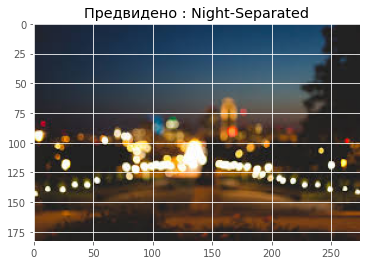

In [49]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSD5hi4bTXtcD-T5eog7z8jOTPA4mHunqGyJQ&usqp=CAU")

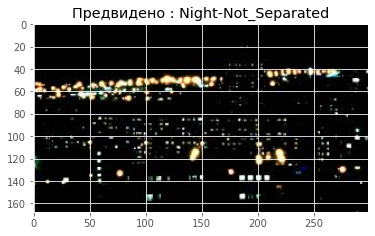

In [50]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRJi3-W7_boSa2tqjVvioE2Leiz7h4yvM6lg&usqp=CAU")